# Trees - Modelling

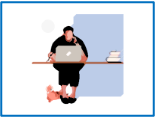

## PROBLEM: With given dataset, predict the probability of the payment within 90 days!

This is a small sample of data (both in terms of observations and available variables) that is actually used for training our models in *****. All the IDs are replaced, and all datapoints have a slight noise added to them to avoid any chance of identification. Data is stored as a small SQLite database stored in attached `session_11.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

In [309]:
import sqlite3
import sweetviz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
con = sqlite3.connect('./session_11.db')

df_metadata = pd.read_sql_query('SELECT * FROM metadata;', con)
df_metadata

,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


### Some background information on the data

`ct090` — Target <br>
`case_id` — Unique identifier <br>
`keydate` — point in time when some event has happened in the lifecycle of a case + date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!

Metadata gives some basic description of variables. The general naming convention is based on prefixes that define aggregation levels - `cXXXX` looking at the data of this case only, `dXXXX` looking at other cases of same debtor, `bXXXX` looking at all cases of the debtor, `aXXXX` looking at all the cases on the same address. This is not very relevant for this particular task, but gives some idea of our data setup here in ******! Note that this data selection has quite a few variables with the `dXXXX` prefix, which means that this selection is specifically looking at debtors that we already had worked with before, therefore, variable selection is much broader and models are generally better. 

One more tip on interpretation of missing values: if variable is bound by time window, e.g. `d2112 NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach. 


# Solution

### First look at the data

#### Metadata

In [310]:
print("Type of data:", type(df_metadata))
print("\nDimensions: \nNumber of rows:",df_metadata.shape[0], "\nNumber of columns:",df_metadata.shape[1])
df_metadata

Type of data: <class 'pandas.core.frame.DataFrame'>

Dimensions: 
Number of rows: 17 
Number of columns: 4


,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


Looking at this dataset I came to conclusion that I would need the names to replace the code in the main dataset. That is why I will modify the names and make it shorter.

In [311]:
# function to convert camel case to snake case
def camel_to_snake(name):
    import re
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# rename code names using the camel_to_snake function
df_metadata['name'] = df_metadata['name'].apply(camel_to_snake)

# print the modified DataFrame
pd.set_option('display.max_colwidth', None)
df_metadata.name


0     ratio_of_customers_at_address_with_successfully_closed_cases_last36_months
1                                                           target_amount90_days
2                                              original_capital_of_case_invoices
3                                                                 amount_of_case
4                                                                    age_of_debt
5                                                        number_of_telephones_ci
6                                                                  industry_code
7                                                                    client_name
8                                                                   customer_age
9                                                                  target90_days
10                               amount_of_customer_payments_on_all_cases_blevel
11                                                 amount_of_customer_open_cases
12                          

In [312]:
df_metadata.replace({'name' : 
            { 
    "ratio_of_customers_at_address_with_successfully_closed_cases_last36_months": "customers_at_address/success_closed_cases_36M", 
    "original_capital_of_case_invoices": "original_capital",
    "number_of_telephones_ci":"no.telephones",
    "amount_of_customer_payments_on_all_cases_blevel": "cust_payments_all_cases",
    "last_original_closing_code_of_customer": "last_original_closing_code",
    "number_of_customer_incoming_call_dates_tee":"cust_incoming_call_dates",
    "number_of_successfully_closed_cases_in_last24_months": "success_closed_cases_24M",
    "number_of_customer_payments_in_last12_months":"cust_payments_12M",
    "number_of_unsuccessfully_closed_customer_cases_last36_months": "failed_closed_cust_cases_36M"    

}}, inplace=True)

In [313]:
df_metadata

,varcode,name,var_class,entity_table
0,a8404,customers_at_address/success_closed_cases_36M,variable,address
1,ap090,target_amount90_days,target,case
2,c0001,original_capital,variable,case
3,c0015,amount_of_case,variable,case
4,c0019,age_of_debt,variable,case
5,c0031,no.telephones,variable,case
6,c0039,industry_code,variable,case
7,c0044,client_name,variable,case
8,c9008,customer_age,variable,case
9,ct090,target90_days,target,case


#### Main Dataset

In [314]:
df_dataset = pd.read_sql_query('SELECT * FROM dataset;', con)
print("Type of data:", type(df_dataset))
print("\nDimensions: \nNumber of rows:",df_dataset.shape[0], "\nNumber of columns:",df_dataset.shape[1])
df_dataset

Type of data: <class 'pandas.core.frame.DataFrame'>

Dimensions: 
Number of rows: 30000 
Number of columns: 19


,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.00,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.00,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,2017-05-22 00:00:00.0,0.0,0.0,435.46,K6512,27,NaN,978.62,242.06,3.0,1.00,4.0,0.0,40.0,3.0,7,1.0,435.46
29996,29997,2017-08-20 00:00:00.0,1.0,188.4,344.07,K6512,10,NaN,NaN,25408.75,2.0,0.27,111.0,1.0,40.0,NaN,4,NaN,372.48
29997,29998,2017-06-11 00:00:00.0,0.0,0.0,417.23,K6512,6,1.0,NaN,0.00,3.0,0.09,103.0,0.0,41.0,NaN,1,NaN,516.45
29998,29999,2017-02-17 00:00:00.0,0.0,0.0,529.00,K6512,11,NaN,101.90,0.00,2.0,NaN,199.0,0.0,54.0,0.0,6,1.0,544.00


In [315]:
#Basic Information about dataset
df_dataset.info()

df_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   case_id  30000 non-null  int64  
 1   keydate  30000 non-null  object 
 2   ct090    30000 non-null  float64
 3   ap090    30000 non-null  float64
 4   c0001    29975 non-null  float64
 5   c0039    30000 non-null  object 
 6   c0044    30000 non-null  object 
 7   d0031    17371 non-null  float64
 8   b0007    13074 non-null  float64
 9   d0009    30000 non-null  float64
 10  c0031    30000 non-null  float64
 11  a8404    19599 non-null  float64
 12  c0019    30000 non-null  float64
 13  d0027    30000 non-null  float64
 14  c9008    27016 non-null  float64
 15  d2112    13048 non-null  float64
 16  d0012    30000 non-null  object 
 17  d1205    8762 non-null   float64
 18  c0015    30000 non-null  float64
dtypes: float64(14), int64(1), object(4)
memory usage: 4.3+ MB


,case_id,ct090,ap090,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
count,30000.000000,30000.000000,30000.000000,29975.000000,17371.000000,13074.000000,30000.000000,30000.000000,19599.000000,30000.000000,30000.000000,27016.000000,13048.000000,8762.000000,30000.000000
mean,15000.500000,0.168733,49.215836,538.590694,1.634391,423.156043,555.063823,3.092900,0.283395,104.948833,0.473067,42.339466,0.935622,0.897170,605.535361
std,8660.398374,0.374522,240.063401,1248.533877,1.318419,902.166491,1939.588574,2.151021,0.312366,196.864753,1.397094,13.215883,1.755761,0.814515,1223.783876
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-319.010000,0.000000,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,9.750000
25%,7500.750000,0.000000,0.000000,145.100000,1.000000,76.000000,0.000000,2.000000,0.000000,10.000000,0.000000,32.000000,0.000000,0.000000,185.410000
50%,15000.500000,0.000000,0.000000,298.720000,1.000000,202.715000,0.000000,3.000000,0.210000,77.000000,0.000000,41.000000,0.000000,1.000000,355.650000
75%,22500.250000,0.000000,0.000000,638.645000,2.000000,500.677500,481.322500,4.000000,0.450000,126.000000,0.000000,51.000000,1.000000,1.000000,725.480000
max,30000.000000,1.000000,25000.000000,84561.840000,15.000000,53982.610000,110158.640000,35.000000,1.000000,6193.000000,40.000000,117.000000,24.000000,15.000000,84561.840000


In [316]:
#Check for non-numerical columns
df_dataset.select_dtypes(exclude=np.number)

,keydate,c0039,c0044,d0012
0,2017-08-12 00:00:00.0,K6622,1,1
1,2017-02-03 00:00:00.0,K6512,2,2
2,2017-02-17 00:00:00.0,K6512,3,3
3,2017-09-18 00:00:00.0,K6622,4,4
4,2017-07-22 00:00:00.0,K6512,5,1
...,...,...,...,...
29995,2017-05-22 00:00:00.0,K6512,27,7
29996,2017-08-20 00:00:00.0,K6512,10,4
29997,2017-06-11 00:00:00.0,K6512,6,1
29998,2017-02-17 00:00:00.0,K6512,11,6


In [317]:
df_metadata['name']

0     customers_at_address/success_closed_cases_36M
1                              target_amount90_days
2                                  original_capital
3                                    amount_of_case
4                                       age_of_debt
5                                     no.telephones
6                                     industry_code
7                                       client_name
8                                      customer_age
9                                     target90_days
10                          cust_payments_all_cases
11                    amount_of_customer_open_cases
12                       last_original_closing_code
13                         cust_incoming_call_dates
14                         success_closed_cases_24M
15                                cust_payments_12M
16                     failed_closed_cust_cases_36M
Name: name, dtype: object

In [318]:
#Rename columns in df_dataset:

# create a dictionary to map column names from df_dataset to df_metadata
column_map = dict(zip(df_metadata['varcode'], df_metadata['name']))
# rename columns in df_dataset using the column_map dictionary
df_dataset = df_dataset.rename(columns=column_map)

pd.set_option('display.max_colwidth', 0)
df_dataset.set_index("case_id")
df_dataset

,case_id,keydate,target90_days,target_amount90_days,original_capital,industry_code,client_name,failed_closed_cust_cases_36M,cust_payments_all_cases,amount_of_customer_open_cases,no.telephones,customers_at_address/success_closed_cases_36M,age_of_debt,cust_incoming_call_dates,customer_age,cust_payments_12M,last_original_closing_code,success_closed_cases_24M,amount_of_case
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.00,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.00,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,2017-05-22 00:00:00.0,0.0,0.0,435.46,K6512,27,NaN,978.62,242.06,3.0,1.00,4.0,0.0,40.0,3.0,7,1.0,435.46
29996,29997,2017-08-20 00:00:00.0,1.0,188.4,344.07,K6512,10,NaN,NaN,25408.75,2.0,0.27,111.0,1.0,40.0,NaN,4,NaN,372.48
29997,29998,2017-06-11 00:00:00.0,0.0,0.0,417.23,K6512,6,1.0,NaN,0.00,3.0,0.09,103.0,0.0,41.0,NaN,1,NaN,516.45
29998,29999,2017-02-17 00:00:00.0,0.0,0.0,529.00,K6512,11,NaN,101.90,0.00,2.0,NaN,199.0,0.0,54.0,0.0,6,1.0,544.00


In [319]:
#we do not need case_id because we have an index already
df_dataset.drop('case_id', axis=1, inplace=True)
df_dataset

,keydate,target90_days,target_amount90_days,original_capital,industry_code,client_name,failed_closed_cust_cases_36M,cust_payments_all_cases,amount_of_customer_open_cases,no.telephones,customers_at_address/success_closed_cases_36M,age_of_debt,cust_incoming_call_dates,customer_age,cust_payments_12M,last_original_closing_code,success_closed_cases_24M,amount_of_case
0,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.00,748.0,0.0,48.0,NaN,3,NaN,56.84
3,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.00,8.0,0.0,27.0,NaN,4,NaN,463.15
4,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2017-05-22 00:00:00.0,0.0,0.0,435.46,K6512,27,NaN,978.62,242.06,3.0,1.00,4.0,0.0,40.0,3.0,7,1.0,435.46
29996,2017-08-20 00:00:00.0,1.0,188.4,344.07,K6512,10,NaN,NaN,25408.75,2.0,0.27,111.0,1.0,40.0,NaN,4,NaN,372.48
29997,2017-06-11 00:00:00.0,0.0,0.0,417.23,K6512,6,1.0,NaN,0.00,3.0,0.09,103.0,0.0,41.0,NaN,1,NaN,516.45
29998,2017-02-17 00:00:00.0,0.0,0.0,529.00,K6512,11,NaN,101.90,0.00,2.0,NaN,199.0,0.0,54.0,0.0,6,1.0,544.00


### Exploratory Data Analysis (EDA) & Data Cleaning

In this part, I decided to simultenously explore, visualize, and correct variables and common problems aassociated with data. I will concentrate on distribution and provide more context before deciding on transformation, normalization, and scailing. Instead of creating multiple lines of code for each graph I will use a valuable tool — Visual Analytics — to provide the reader with the multiple intercative graphs in a one window. Then I will move to investigating the distribution of each variable and applying neccesary changes, if needed.

When it comes to particular cleaning processes, I will look at (if necessary) :

1. Missing Values
2. Duplicates
3. Irrelevant data
4. Outliers
5. Typos and wrong string values
6. Standarization
7. Transformation
8. Normalization

### General Analysis

In [320]:
from pandas_visual_analysis import VisualAnalysis

VisualAnalysis(df_dataset)

<i> Because Visual Analysis library is not visible in html mode I include the screenshot <i>
    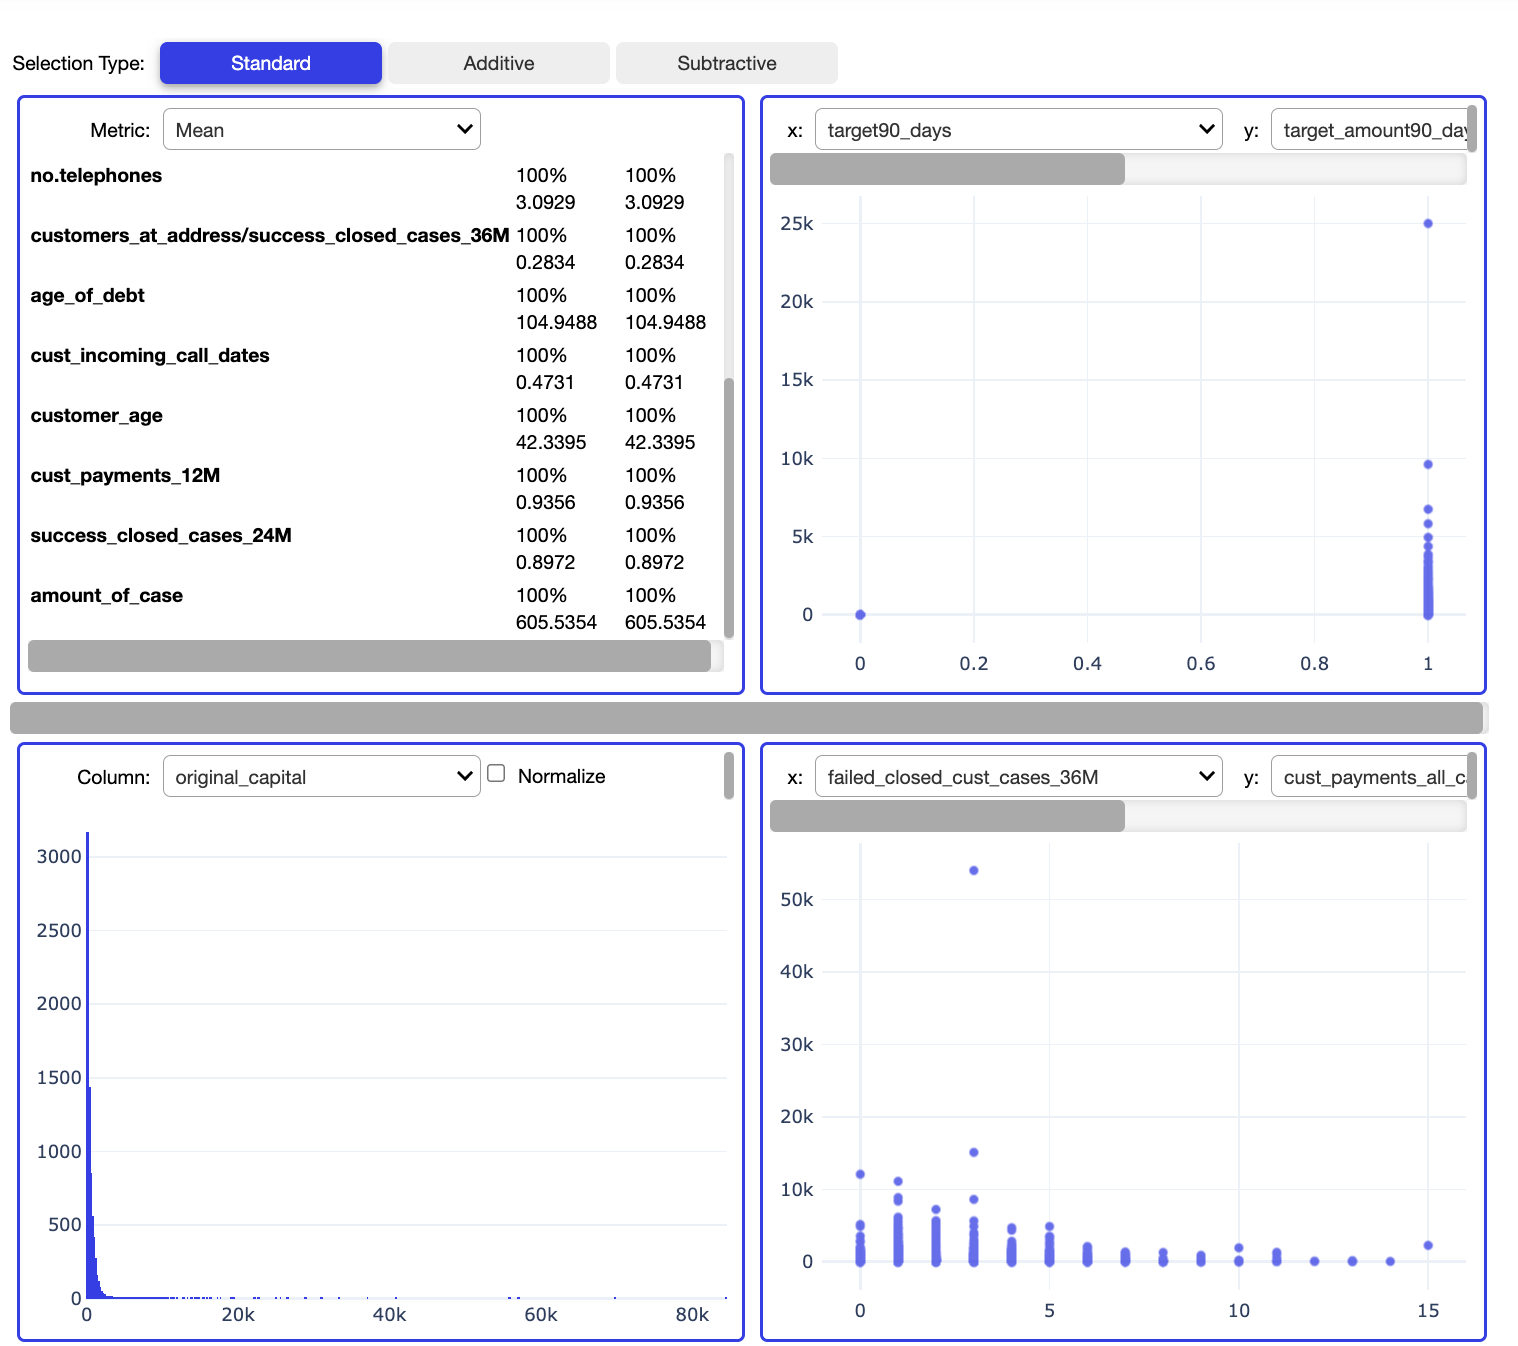

In [321]:
#Check for duplicates
print("Number of Duplicates", df_dataset.duplicated().sum())

Number of Duplicates 0


<b> Comment <b>

Fortunately, we do not have duplicates in our dataset.

From the previous interactive graph we see that distribution of many of our variables are rather (highly) shewed.
    
   In cases, where the payment was not done within 90 days, those cases have higher range of initial capital, and far more occurences of initial capital greater than 20k which is almost not the case of those indeed paid within 90 days.

Also, in the cases when payment was not done, there was a bigger amount of customer open cases and in those cases we can detect higher number of telephones.

Crucially, in payments failed (target90_days = 0), the age of debt of those cases range much higher, frequently above 2000, up to 6000.

Interestingly enough, client who did not pay within 90 days have far more outliers when it comes to age(e.g. age=6 which is impossible, and age=117 (that’s maximum value for that variable) which is highly improbable) 

However, <b> the most interesting and important conclusion <b> is that our dataset is heavily imbalanced when it comes to the target variable. <b> 
    
 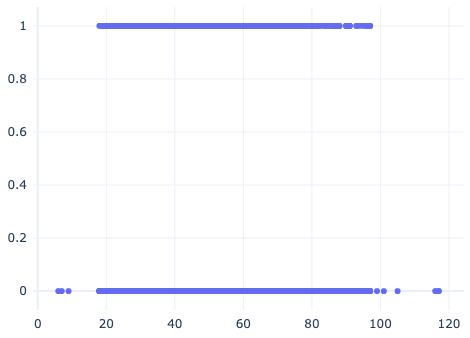
    <center> <i> x-axis: Customer Age <i> <br>
<i> y-axis: Target 90 Days <i> <center>
    

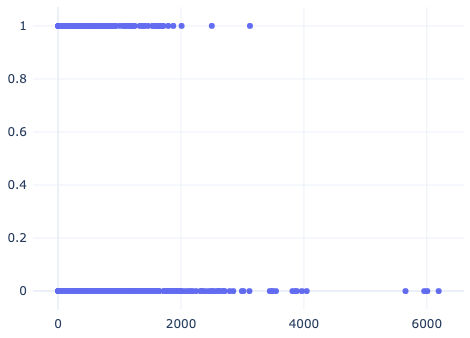
<center> <i> x-axis: Age of Debt <i> <br>
<i> y-axis: Target 90 Days <i> <center>

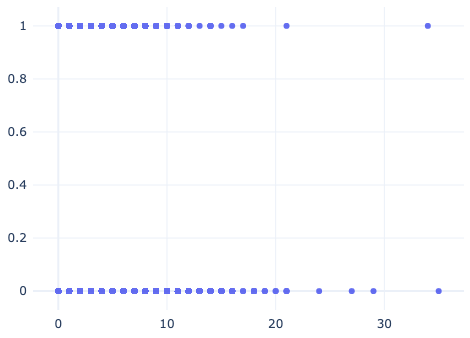
<center> <i> x-axis: no. of telephones <i> <br>
<i> y-axis: Target 90 Days <i> <center>

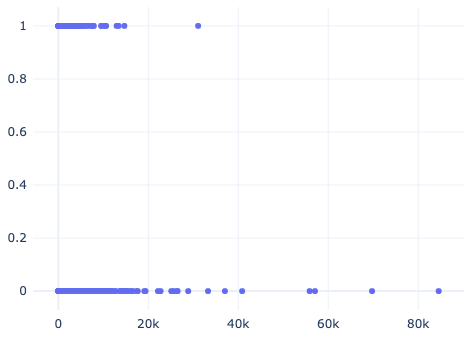
<center> <i> x-axis: Original Capital <i> <br>
<i> y-axis: Target 90 Days <i> <center>

    

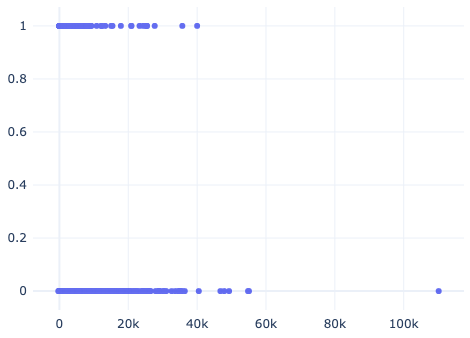
<center> <i> x-axis: Open Cases for Customer <i> <br>
<i> y-axis: Target 90 Days <i> <center>


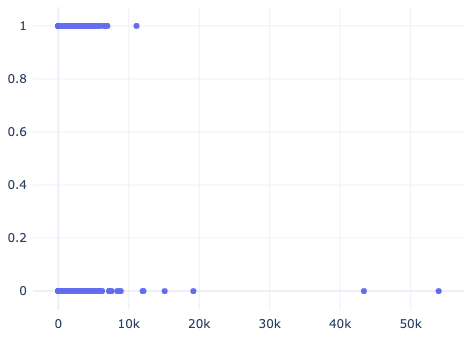
<center> <i> x-axis: All Payments of customer in all cases <i> <br>
<i> y-axis: Target 90 Days <i> <center>


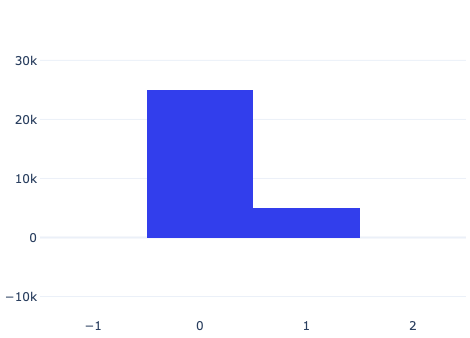

<center> <i>Heavily imbalanced dataset, with the approximate ratio of 6:1 <i> <br>


### Univariate Analysis
In this part, I am interested in investigation of each variable alone — especially in the context of outliers, distribution, and frequencies.

In [322]:
df_dataset1=df_dataset.copy()

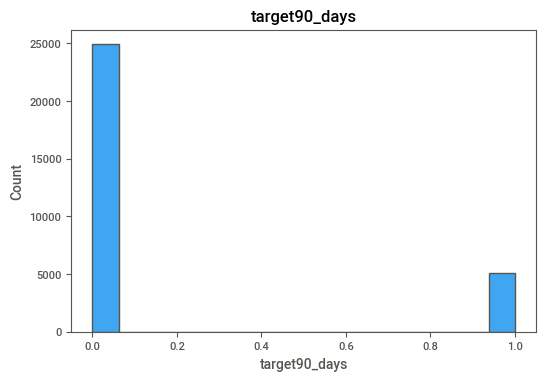

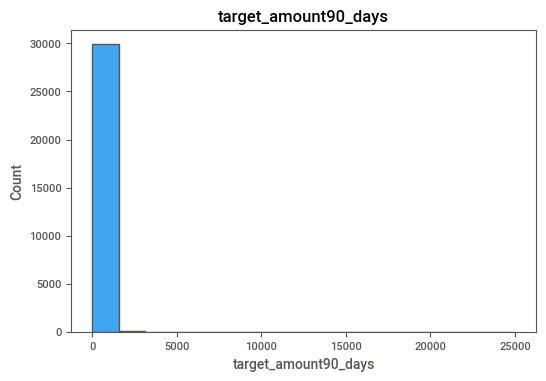

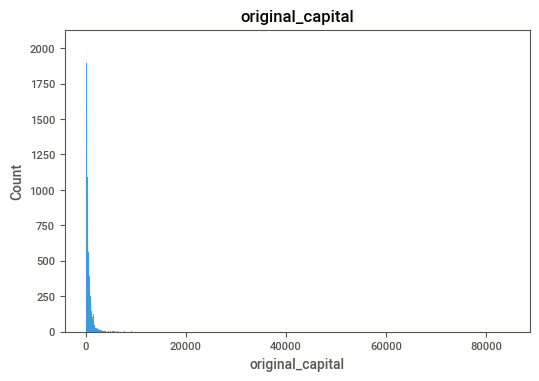

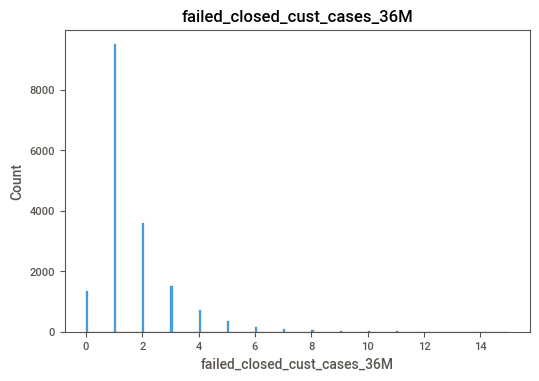

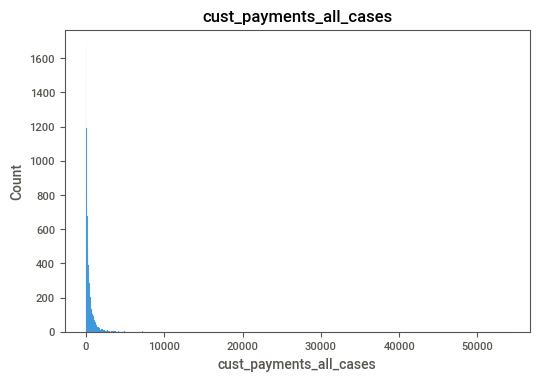

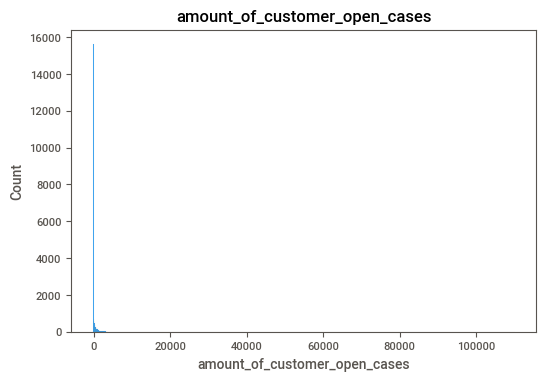

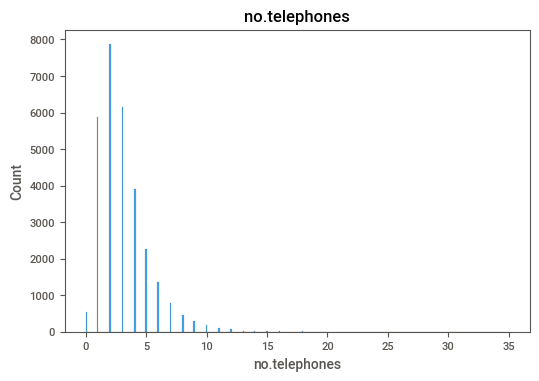

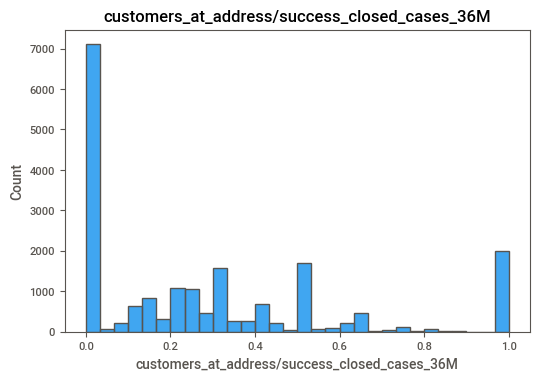

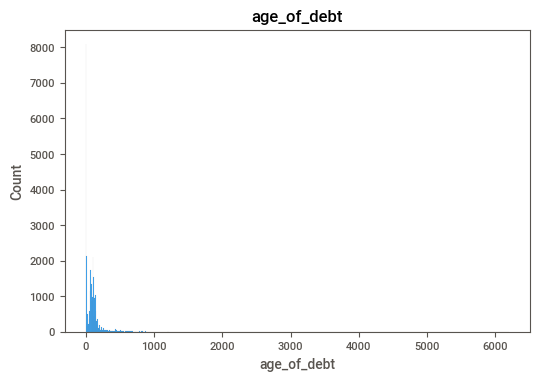

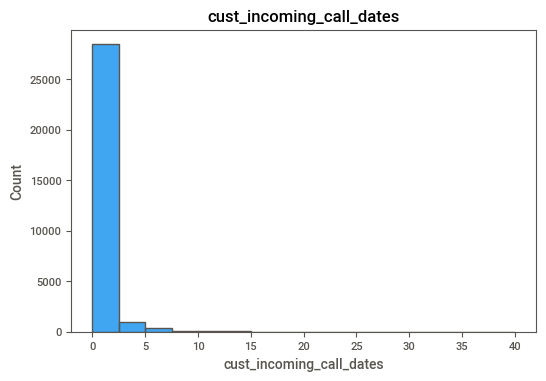

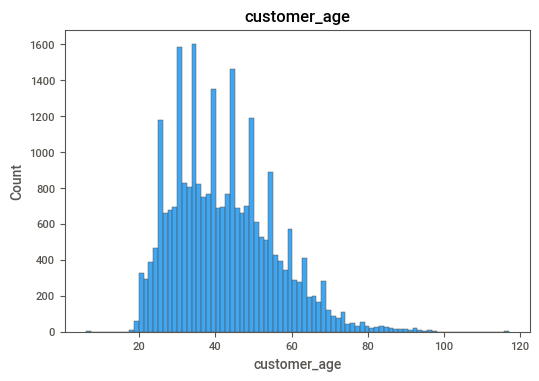

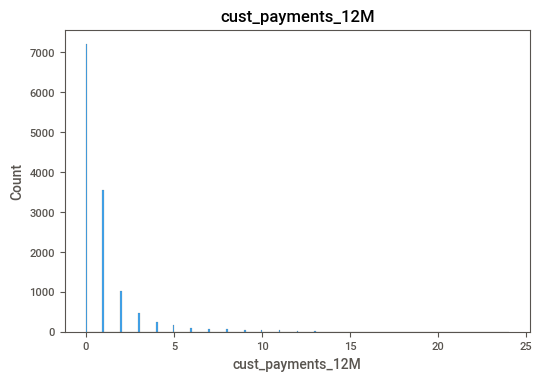

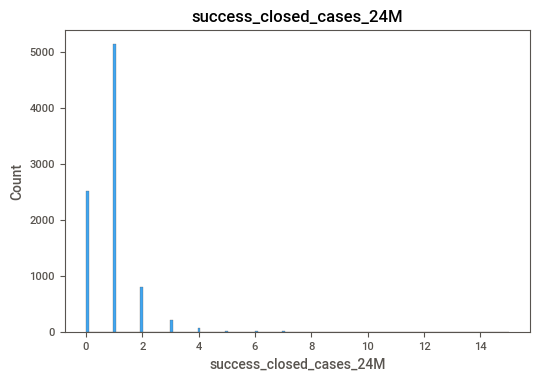

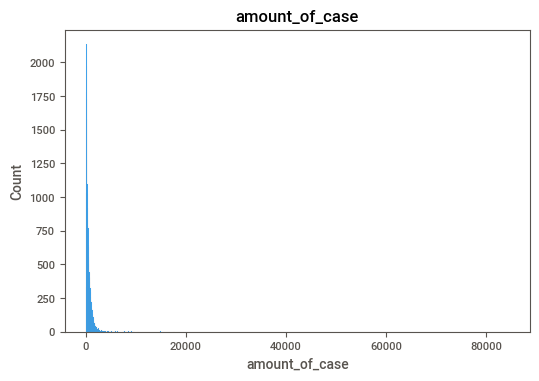

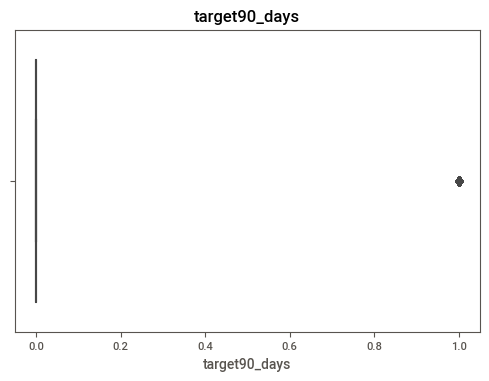

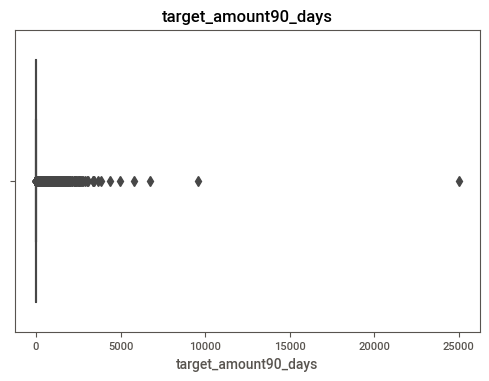

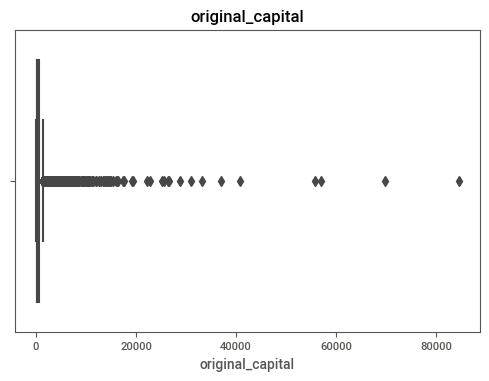

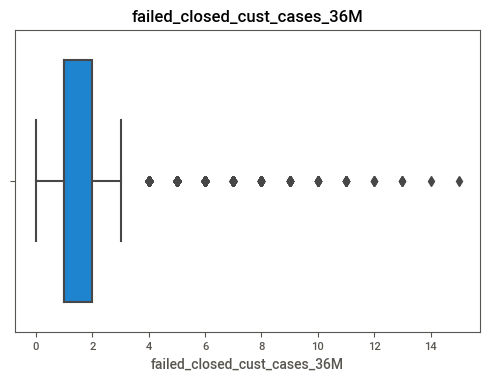

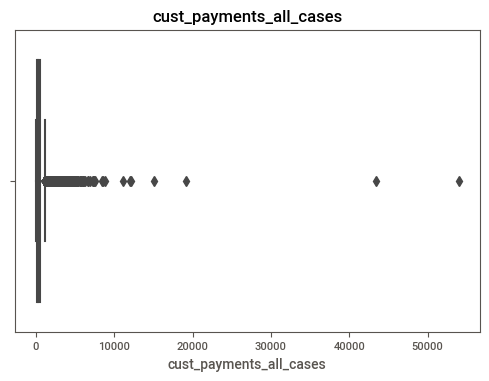

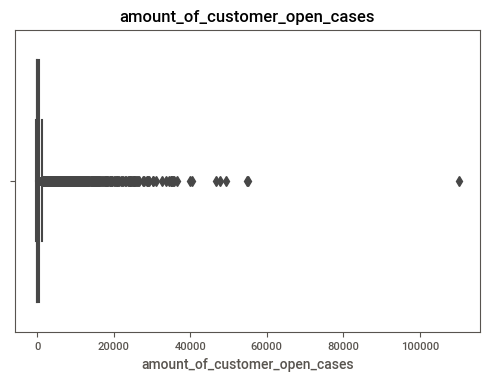

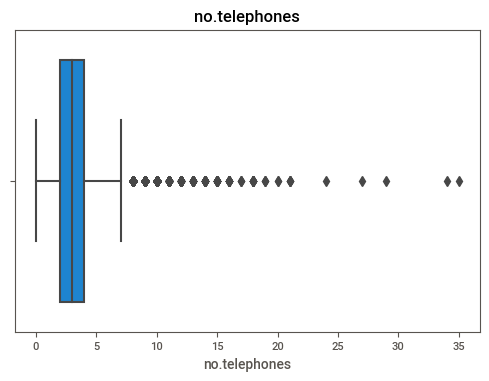

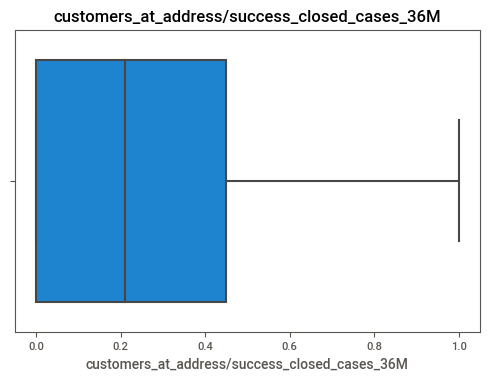

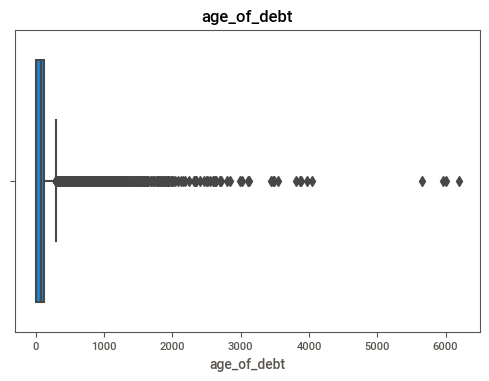

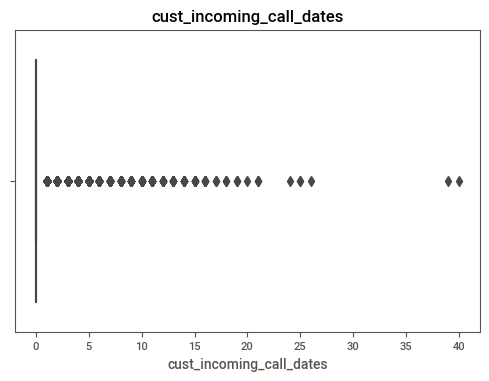

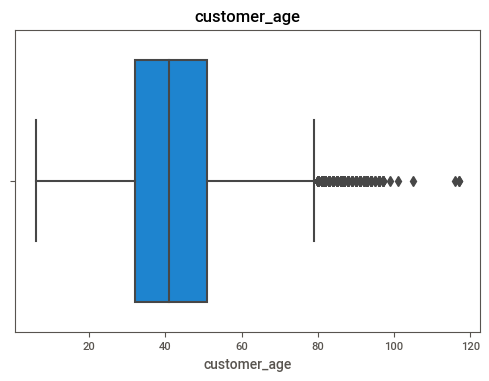

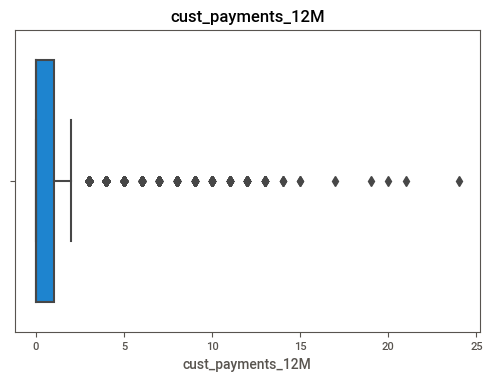

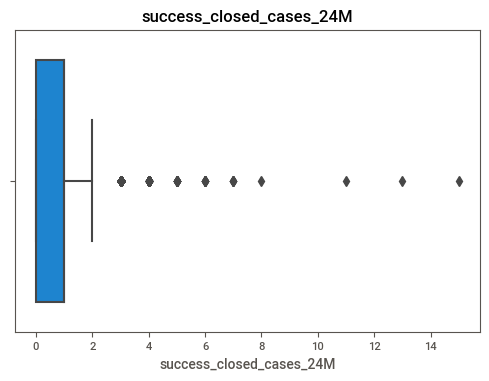

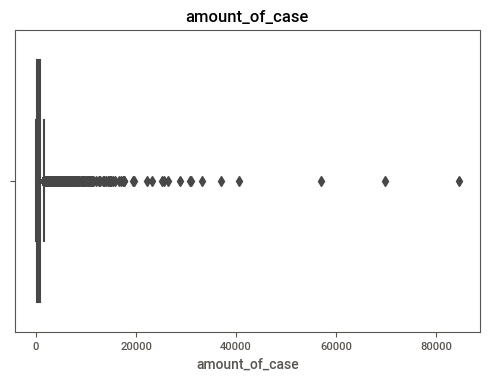

In [323]:
# Univariate Analysis for Numerical Columns
numeric_cols = df_dataset.select_dtypes(include=np.number)

# plot histogram for each numeric column
for col in numeric_cols.columns.tolist():
    sns.histplot(df_dataset[col])
    plt.title(col)
    plt.show()

# plot boxplot for each numeric column
for col in numeric_cols.columns.tolist():
    sns.boxplot(df_dataset[col])
    plt.title(col)
    plt.show()

<b> Comment <b> 

Based on the analysis of graphs above, we can conclude that target variables expose imblanced characteristics. Moreover, when it comes to independent numerical variables, most of them are right-skew. This may be due to:<br><br>
    1. Outliers <br><br>
    2. Floor or Ceiling Effects: In some data sets, there may be lower or upper limits that restrict the range of values that can be measured. This can result in a clustering of data points at the limit.<br><br>
    3. Exponential Growth: When a variable experiences exponential growth, it can cause a right-skewed distribution. This is because the variable will start with low values but experience rapid growth over time, resulting in a few high values that skew the distribution to the right.<br><br>
    4. Sampling Bias: Sampling bias occurs when a data set is not representative of the population from which it was drawn. If the sample is skewed to the right, the resulting data set will also be right-skewed.<br><br>
    5. Limited Precision: Limited precision can occur when data is collected using instruments that have limited measurement accuracy. This can result in a clustering of data points at certain values, leading to a right-skewed distribution.<br><br>
    
    
Moreover, we can clearly see the presence of many outliters (based on boxplot analysis). The problem here is that we don't want to remove data points because we have heavily imabalanced dataset. Removing outliers right now would exacerbate the probem. 

In [324]:
# Univariate Analysis for Non-Numerical Columns
non_numeric_cols = df_dataset.select_dtypes(exclude=np.number)
print(non_numeric_cols.dtypes)
non_numeric_cols

keydate                       object
industry_code                 object
client_name                   object
last_original_closing_code    object
dtype: object


,keydate,industry_code,client_name,last_original_closing_code
0,2017-08-12 00:00:00.0,K6622,1,1
1,2017-02-03 00:00:00.0,K6512,2,2
2,2017-02-17 00:00:00.0,K6512,3,3
3,2017-09-18 00:00:00.0,K6622,4,4
4,2017-07-22 00:00:00.0,K6512,5,1
...,...,...,...,...
29995,2017-05-22 00:00:00.0,K6512,27,7
29996,2017-08-20 00:00:00.0,K6512,10,4
29997,2017-06-11 00:00:00.0,K6512,6,1
29998,2017-02-17 00:00:00.0,K6512,11,6


In [325]:
#Convert keydate column to date formate
df_dataset['keydate'] = pd.to_datetime(df_dataset['keydate'], format='%Y-%m-%d %H:%M:%S.%f')

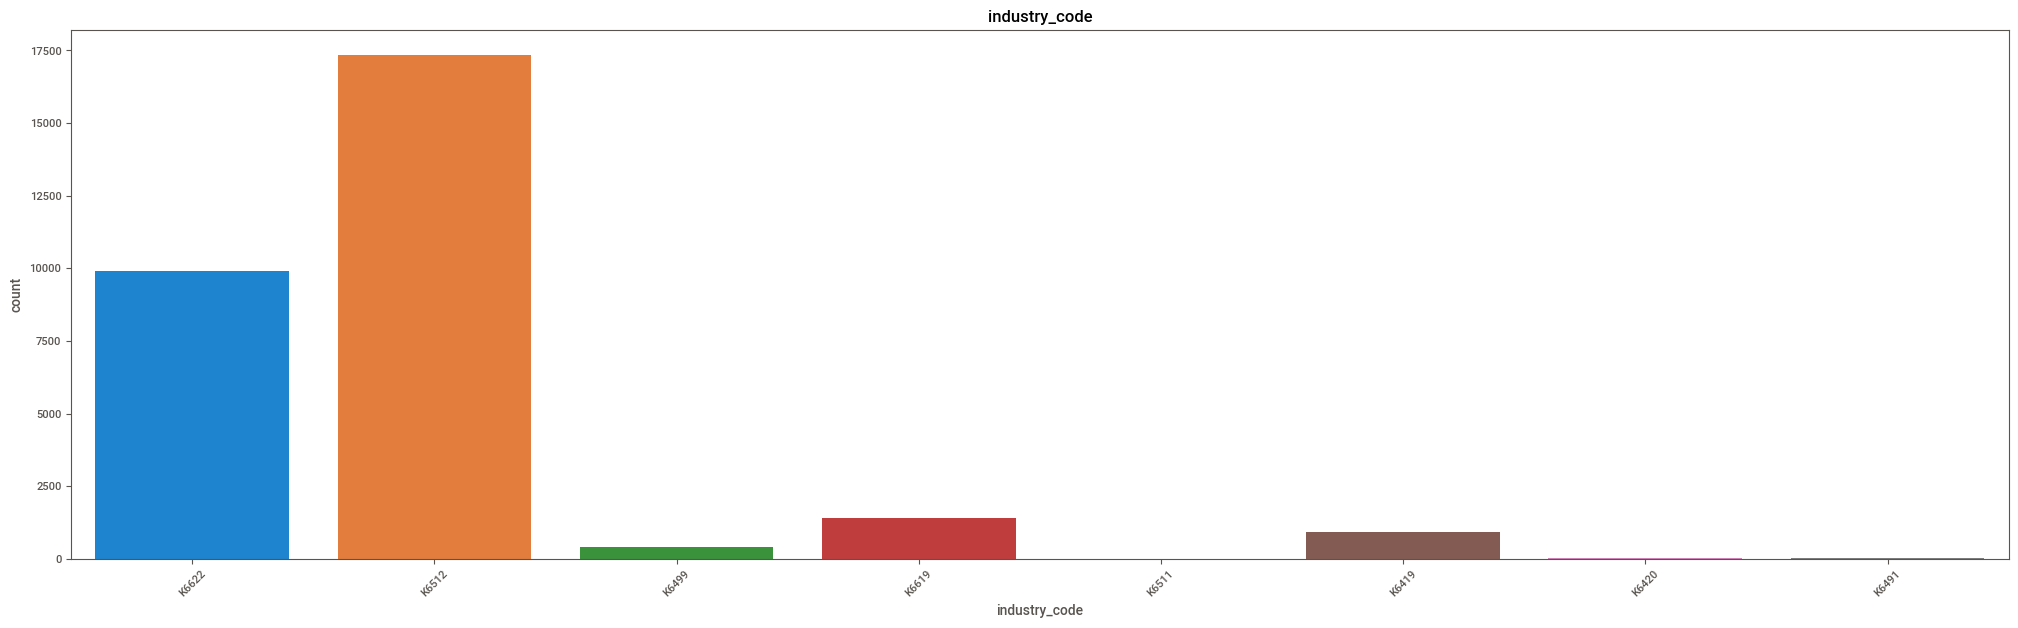

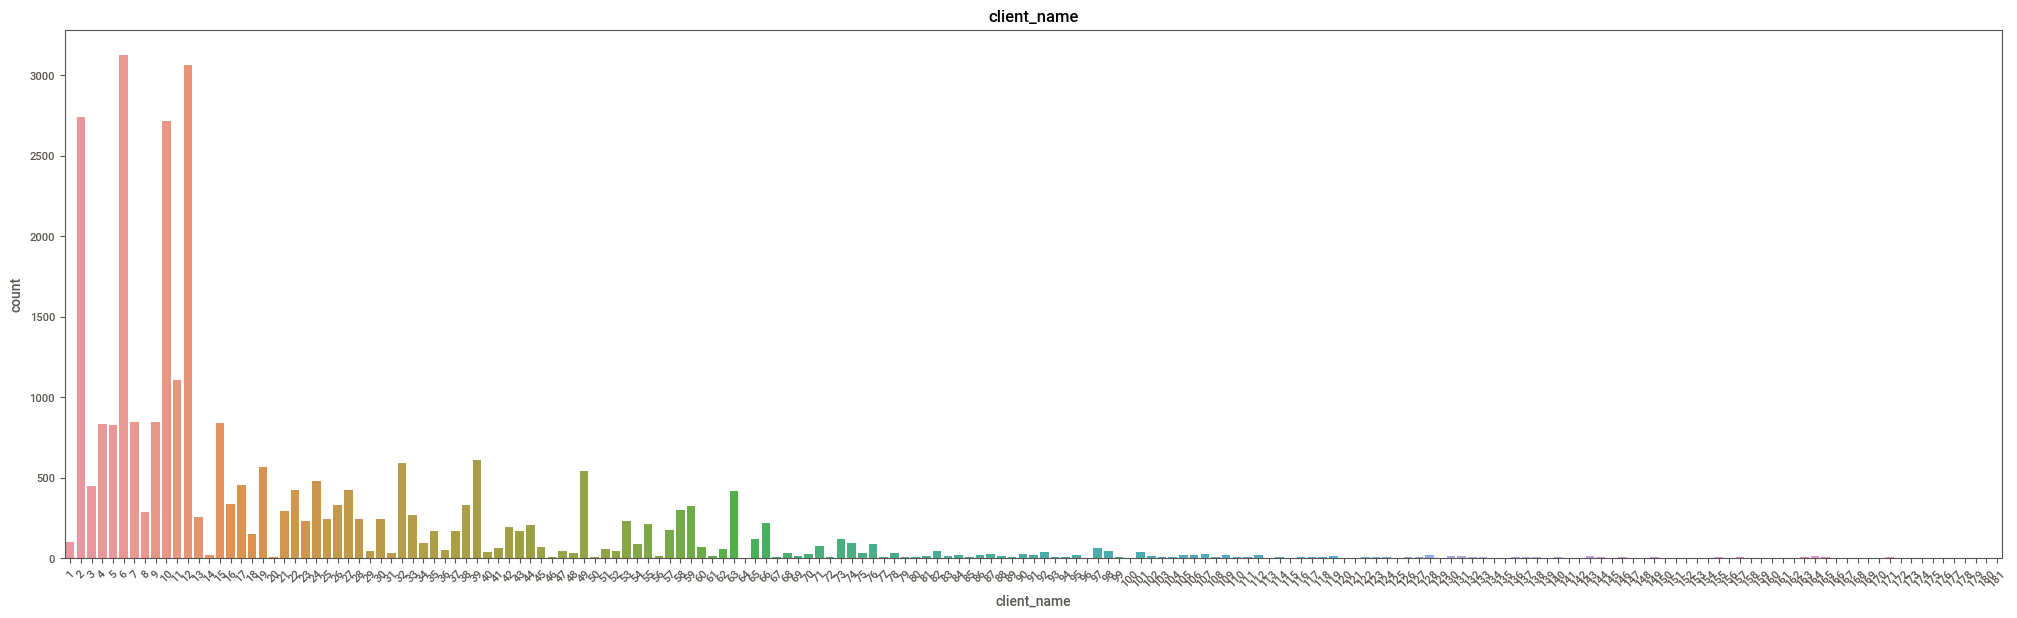

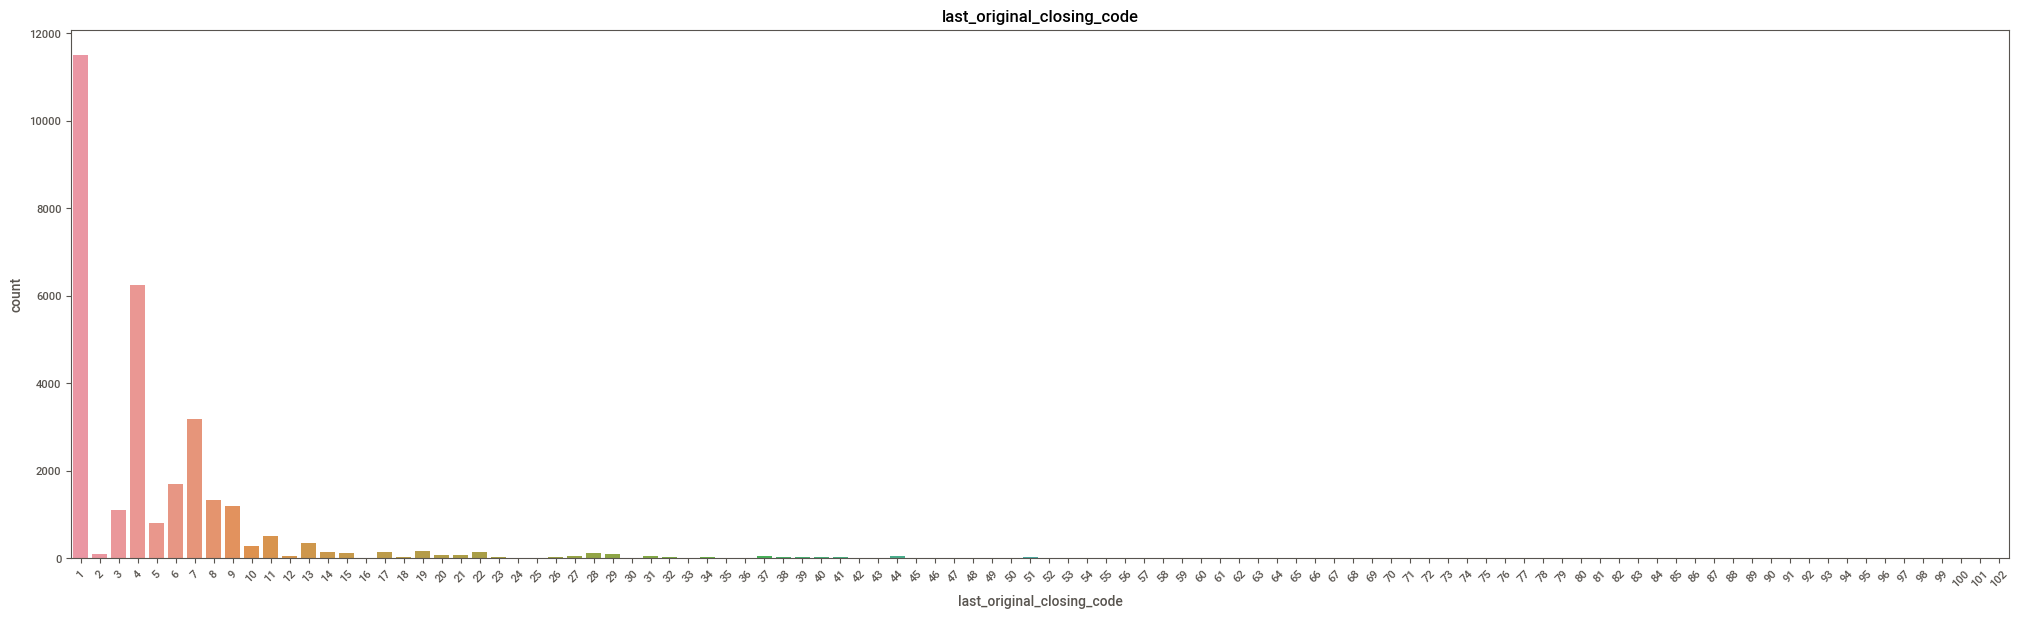

In [326]:
# plot countplot for each non-numeric column
for col in non_numeric_cols.columns.tolist():
    if col == "keydate":
        continue
    fig, ax = plt.subplots(figsize=(25, 7))
    sns.countplot(df_dataset[col])
    
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

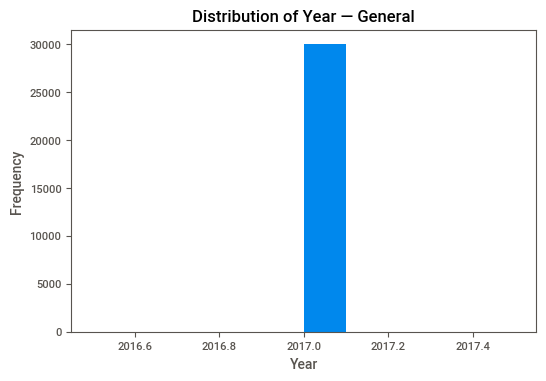

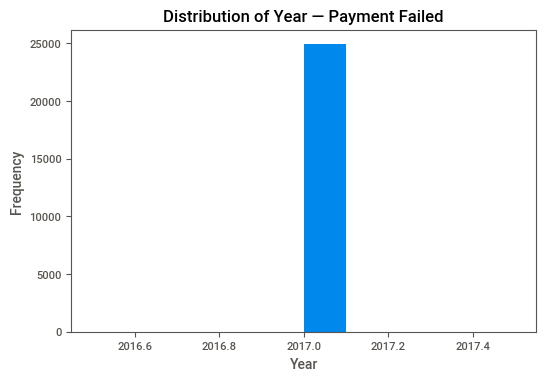

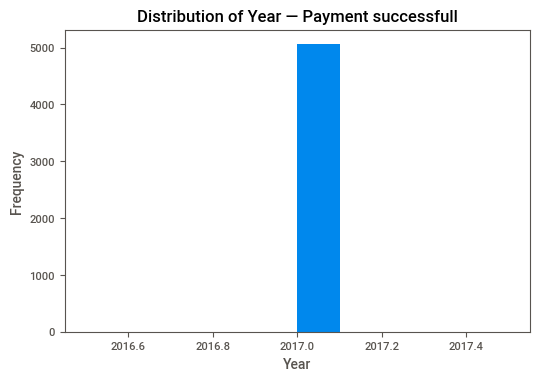

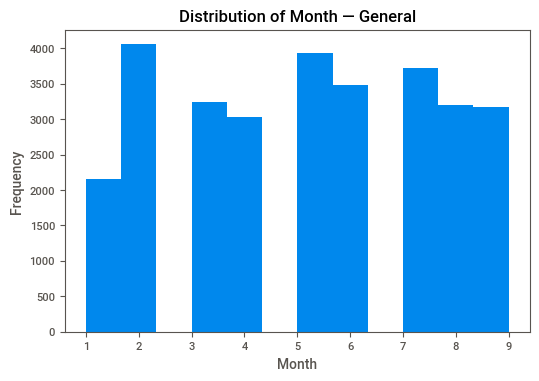

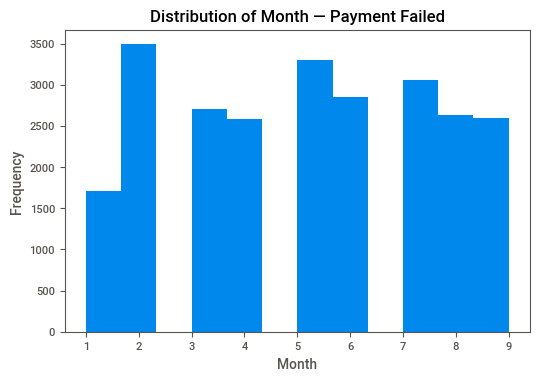

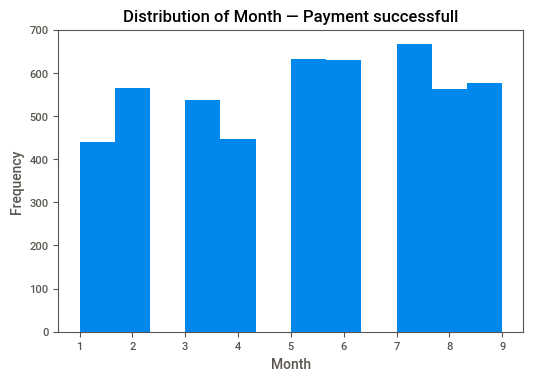

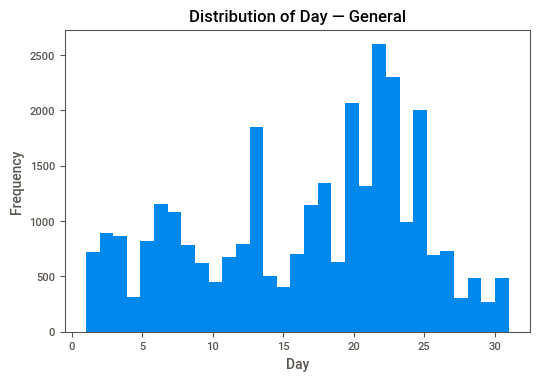

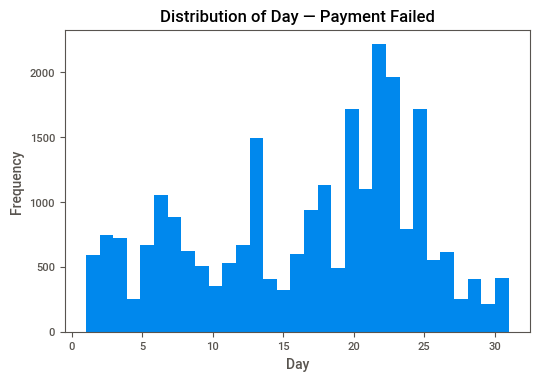

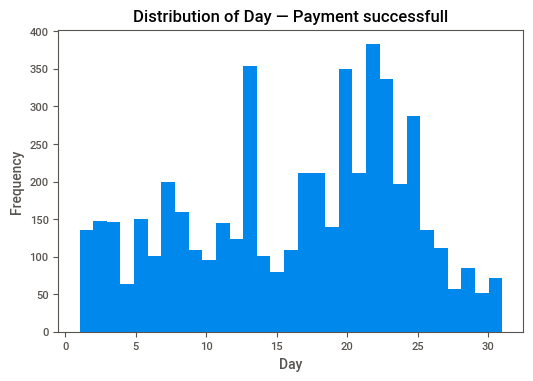

In [327]:
#Analysis of datatime (keydate column)
# Filter the DataFrame to include only rows where target is 1 and then when it's 0
filtered_1 = df_dataset[df_dataset['target90_days'] == 1]
filtered_0 = df_dataset[df_dataset['target90_days'] == 0]

# plot the distribution of the year column
plt.hist(df_dataset['keydate'].dt.year, bins=10)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Year — General')
plt.show()

# plot the distribution of the year column
plt.hist(filtered_0['keydate'].dt.year, bins=10)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Year — Payment Failed')
plt.show()

# plot the distribution of the year column
plt.hist(filtered_1['keydate'].dt.year, bins=10)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Year — Payment successfull')
plt.show()

# plot the distribution of the month column
plt.hist(df_dataset['keydate'].dt.month, bins=12)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Month — General')
plt.show()


# plot the distribution of the month column
plt.hist(filtered_0['keydate'].dt.month, bins=12)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Month — Payment Failed')
plt.show()

# plot the distribution of the month column
plt.hist(filtered_1['keydate'].dt.month, bins=12)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Month — Payment successfull')
plt.show()

# plot the distribution of the day column
plt.hist(df_dataset['keydate'].dt.day, bins=31)
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Distribution of Day — General')
plt.show()

# plot the distribution of the day column
plt.hist(filtered_0['keydate'].dt.day, bins=31)
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Distribution of Day — Payment Failed')
plt.show()

# plot the distribution of the day column
plt.hist(filtered_1['keydate'].dt.day, bins=31)
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Distribution of Day — Payment successfull')
plt.show()

<b> Comment — Key Conclusions: <b> 
1. Cases in our dataset are from 2017.
2. There are more failed payments in February, April, and June as a proportion to total failed cases compared to succesfull cases distribution. 
3. There are more successfull payments in January, March, and Julyas a proportion to successfull failed cases compared to failed cases distribution. 
4. When it comes to day distributions, they all are very similiar. However, interestingly enough, more than usual successfull payments occur around 13th day of the month. This may be due to salary deadline release set by many companies.

### Missing Values

Before further analysis, I decided to first check missing values, because they can heavily impace the distribution and other statistical computations.

original_capital
Missing Values:  25 (0.08%)

failed_closed_cust_cases_36M
Missing Values:  12629 (42.10%)

cust_payments_all_cases
Missing Values:  16926 (56.42%)

customers_at_address/success_closed_cases_36M
Missing Values:  10401 (34.67%)

customer_age
Missing Values:  2984 (9.95%)

cust_payments_12M
Missing Values:  16952 (56.51%)

success_closed_cases_24M
Missing Values:  21238 (70.79%)



<AxesSubplot:>

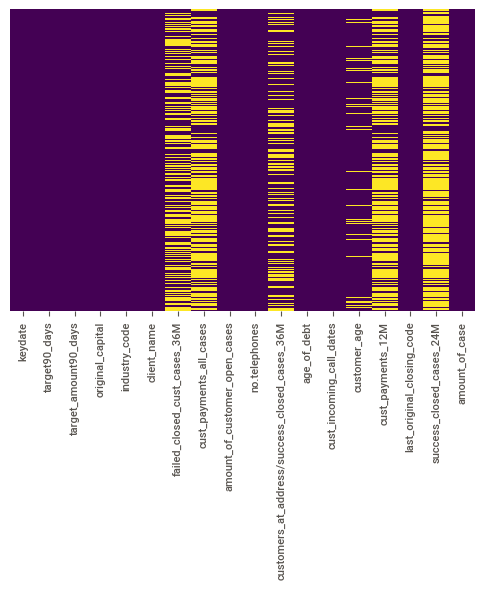

In [328]:
#Missing values for Each Category
for col in df_dataset.columns:
    if df_dataset[col].isnull().values.any():
        print(col)
        missing_count = df_dataset[col].isnull().sum()
        print("Missing Values: ", missing_count,  "({:.2%})\n".format(missing_count/ df_dataset.shape[0]))

sns.heatmap(df_dataset.isnull(), yticklabels=False, cbar=False, cmap="viridis")


<b> Comment <b> 
    
The problem with missing value is severe. Except for original_capital variable, a lot of variables have missing data that constitute a significant percentage of all the cases in the dataset, which is quite alaraming. 
    
Upon further pondering over how this problem should be tackled, I decided that:
original_capital's missing values are a tiny percentage so I decided to drop them. 
 
When it comes to the rest: missing values in those cases constitute more than 1-5% of the total dataset, so I decided to fill in thos missing values. I decided to fill with a mean value, in order to not artificially skew the distribution in one way or another.

In [329]:
df_dataset.dropna(subset=['original_capital'], inplace=True)

#Fill with mean
mean_value=df_dataset['failed_closed_cust_cases_36M'].mean()
df_dataset['failed_closed_cust_cases_36M'].fillna(value=mean_value, inplace=True)

mean_value=df_dataset['cust_payments_all_cases'].mean()
df_dataset['cust_payments_all_cases'].fillna(value=mean_value, inplace=True)

mean_value=df_dataset['customers_at_address/success_closed_cases_36M'].mean()
df_dataset['customers_at_address/success_closed_cases_36M'].fillna(value=mean_value, inplace=True)

mean_value=df_dataset['customer_age'].mean()
df_dataset['customer_age'].fillna(value=mean_value, inplace=True)

mean_value=df_dataset['cust_payments_12M'].mean()
df_dataset['cust_payments_12M'].fillna(value=mean_value, inplace=True)

mean_value=df_dataset['success_closed_cases_24M'].mean()
df_dataset['success_closed_cases_24M'].fillna(value=mean_value, inplace=True)

<AxesSubplot:>

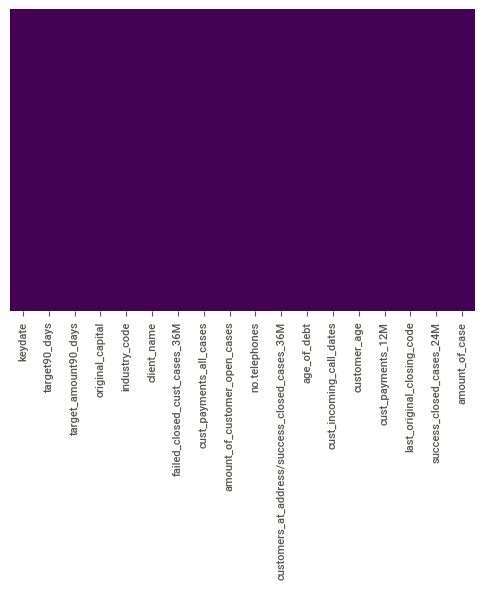

In [330]:
#Missing values for Each Category
for col in df_dataset.columns:
    if df_dataset[col].isnull().values.any():
        print(col)
        missing_count = df_dataset[col].isnull().sum()
        print("Missing Values: ", missing_count,  "({:.2%})\n".format(missing_count/ df_dataset.shape[0]))

sns.heatmap(df_dataset.isnull(), yticklabels=False, cbar=False, cmap="viridis")


## Bivariate Analysis

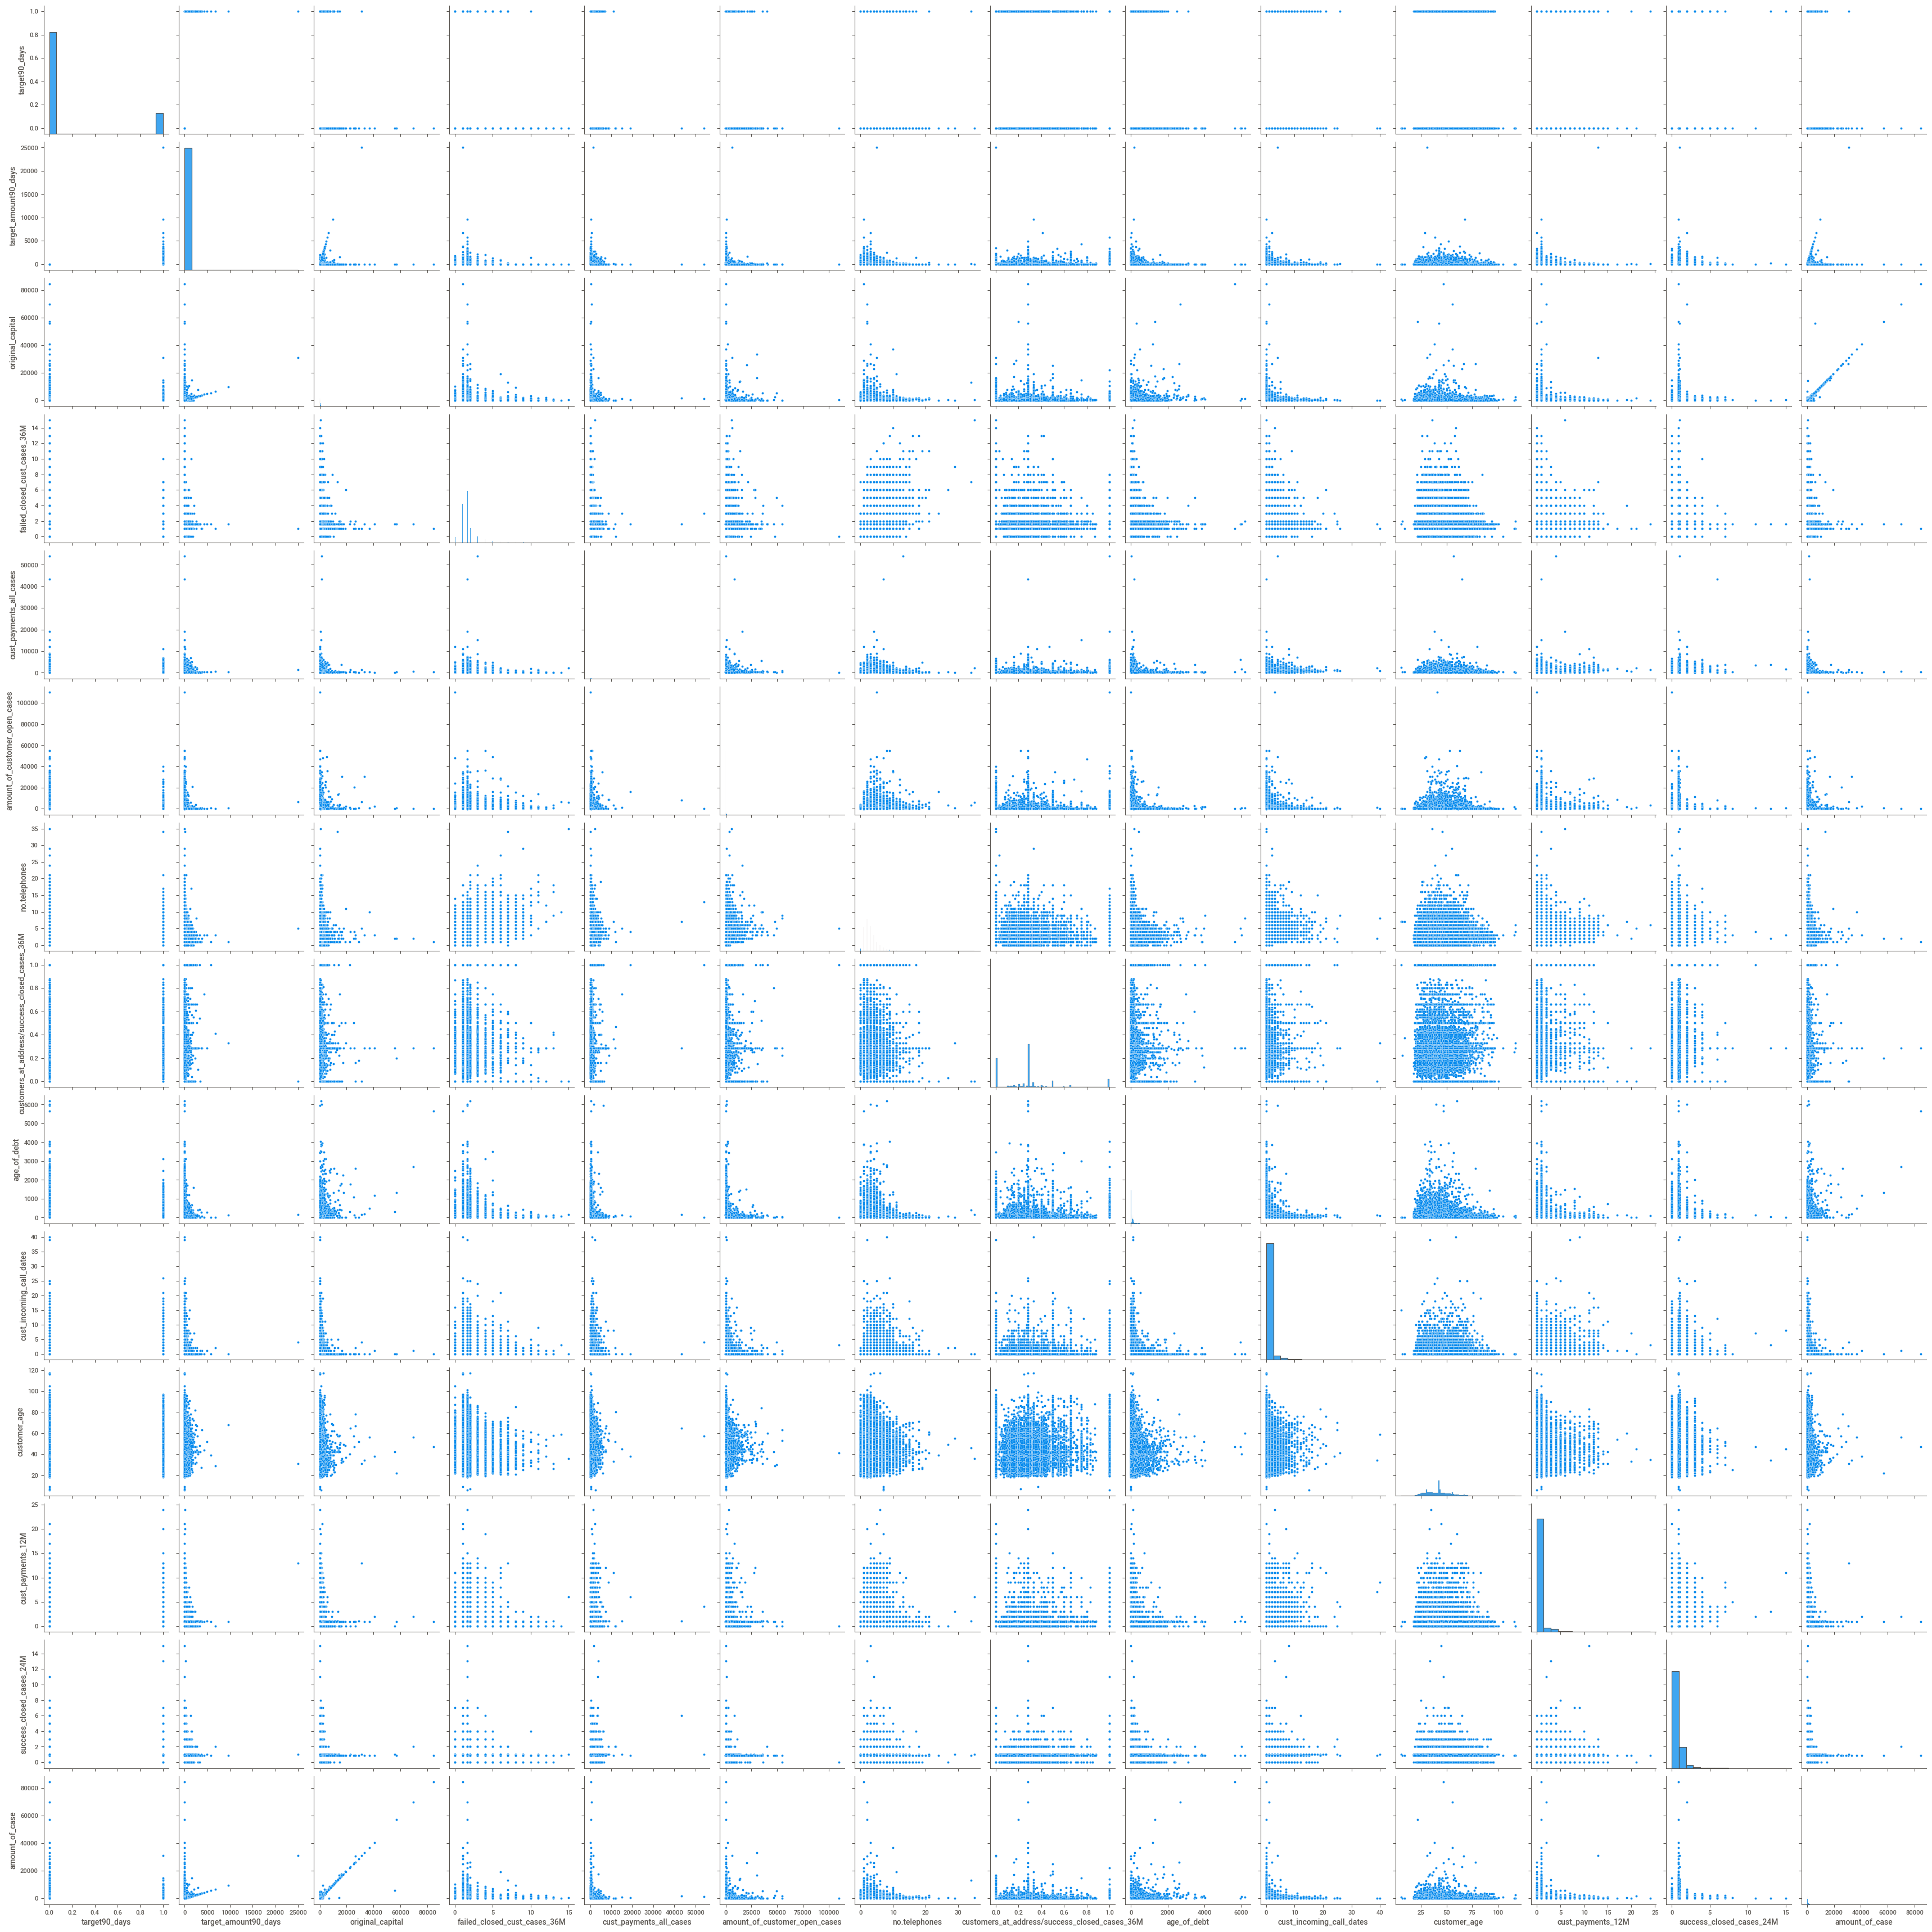

In [50]:
sns.pairplot(df_dataset)
plt.show()

<b> Comment <b> 
    
Next, I want to further investigate keydate column by creating the following table:
    
Create a new column with the year and month information from the keydate column.
thod.
 <br>
Tot - this is the count of rows in each group, computed using the count() method.<br>
Good - this is the count of rows in each group where target90_days is 1, computed using a lambda function.<br>
Bad - this is the count of rows in each group where target90_days is 0, computed using a lambda function.<br>
GoodRate - this is the proportion of rows in each group where target90_days is 1, computed as Good / Tot.<br>
BadRate - this is the proportion of rows in each group where target90_days is 0, computed as Bad / Tot.<br>

In [331]:
from tabulate import tabulate
dataset1=df_dataset.copy()

date_df = df_dataset1.assign(
    key_date=lambda x: (pd.to_numeric(x['keydate'].str[:4]) * 100 + pd.to_numeric(x['keydate'].str[6:7])),
    last_original_closing_code=pd.to_numeric(df_dataset1['last_original_closing_code']),
    client_name=pd.to_numeric(df_dataset1['client_name']),
    industry_code=pd.Categorical(df_dataset1['industry_code'])
).drop(columns=['keydate'])

grouped_df = date_df.groupby('key_date').agg(
    Tot=('key_date', 'count'),
    Good=('target90_days', lambda x: sum(x == 1)),
    Bad=('target90_days', lambda x: sum(x == 0))
).assign(
    GoodRate=lambda x: x.Good / x.Tot,
    BadRate=lambda x: x.Bad / x.Tot
).reset_index()


table = tabulate(grouped_df, headers='keys', tablefmt='heavy_outline', showindex=False)

print(table)

┏━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃   key_date ┃   Tot ┃   Good ┃   Bad ┃   GoodRate ┃   BadRate ┃
┣━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃     201701 ┃  2149 ┃    441 ┃  1708 ┃   0.205212 ┃  0.794788 ┃
┃     201702 ┃  4059 ┃    566 ┃  3493 ┃   0.139443 ┃  0.860557 ┃
┃     201703 ┃  3247 ┃    537 ┃  2710 ┃   0.165383 ┃  0.834617 ┃
┃     201704 ┃  3027 ┃    448 ┃  2579 ┃   0.148001 ┃  0.851999 ┃
┃     201705 ┃  3931 ┃    632 ┃  3299 ┃   0.160773 ┃  0.839227 ┃
┃     201706 ┃  3485 ┃    630 ┃  2855 ┃   0.180775 ┃  0.819225 ┃
┃     201707 ┃  3725 ┃    667 ┃  3058 ┃   0.17906  ┃  0.82094  ┃
┃     201708 ┃  3201 ┃    564 ┃  2637 ┃   0.176195 ┃  0.823805 ┃
┃     201709 ┃  3176 ┃    577 ┃  2599 ┃   0.181675 ┃  0.818325 ┃
┗━━━━━━━━━━━━┻━━━━━━━┻━━━━━━━━┻━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛


### Correlation Analysis

In correlation analysis, we look for variables whose correlation coefficient will be higher than 0.8. In those cases we unnecessary use them because they provide a similiar information. 

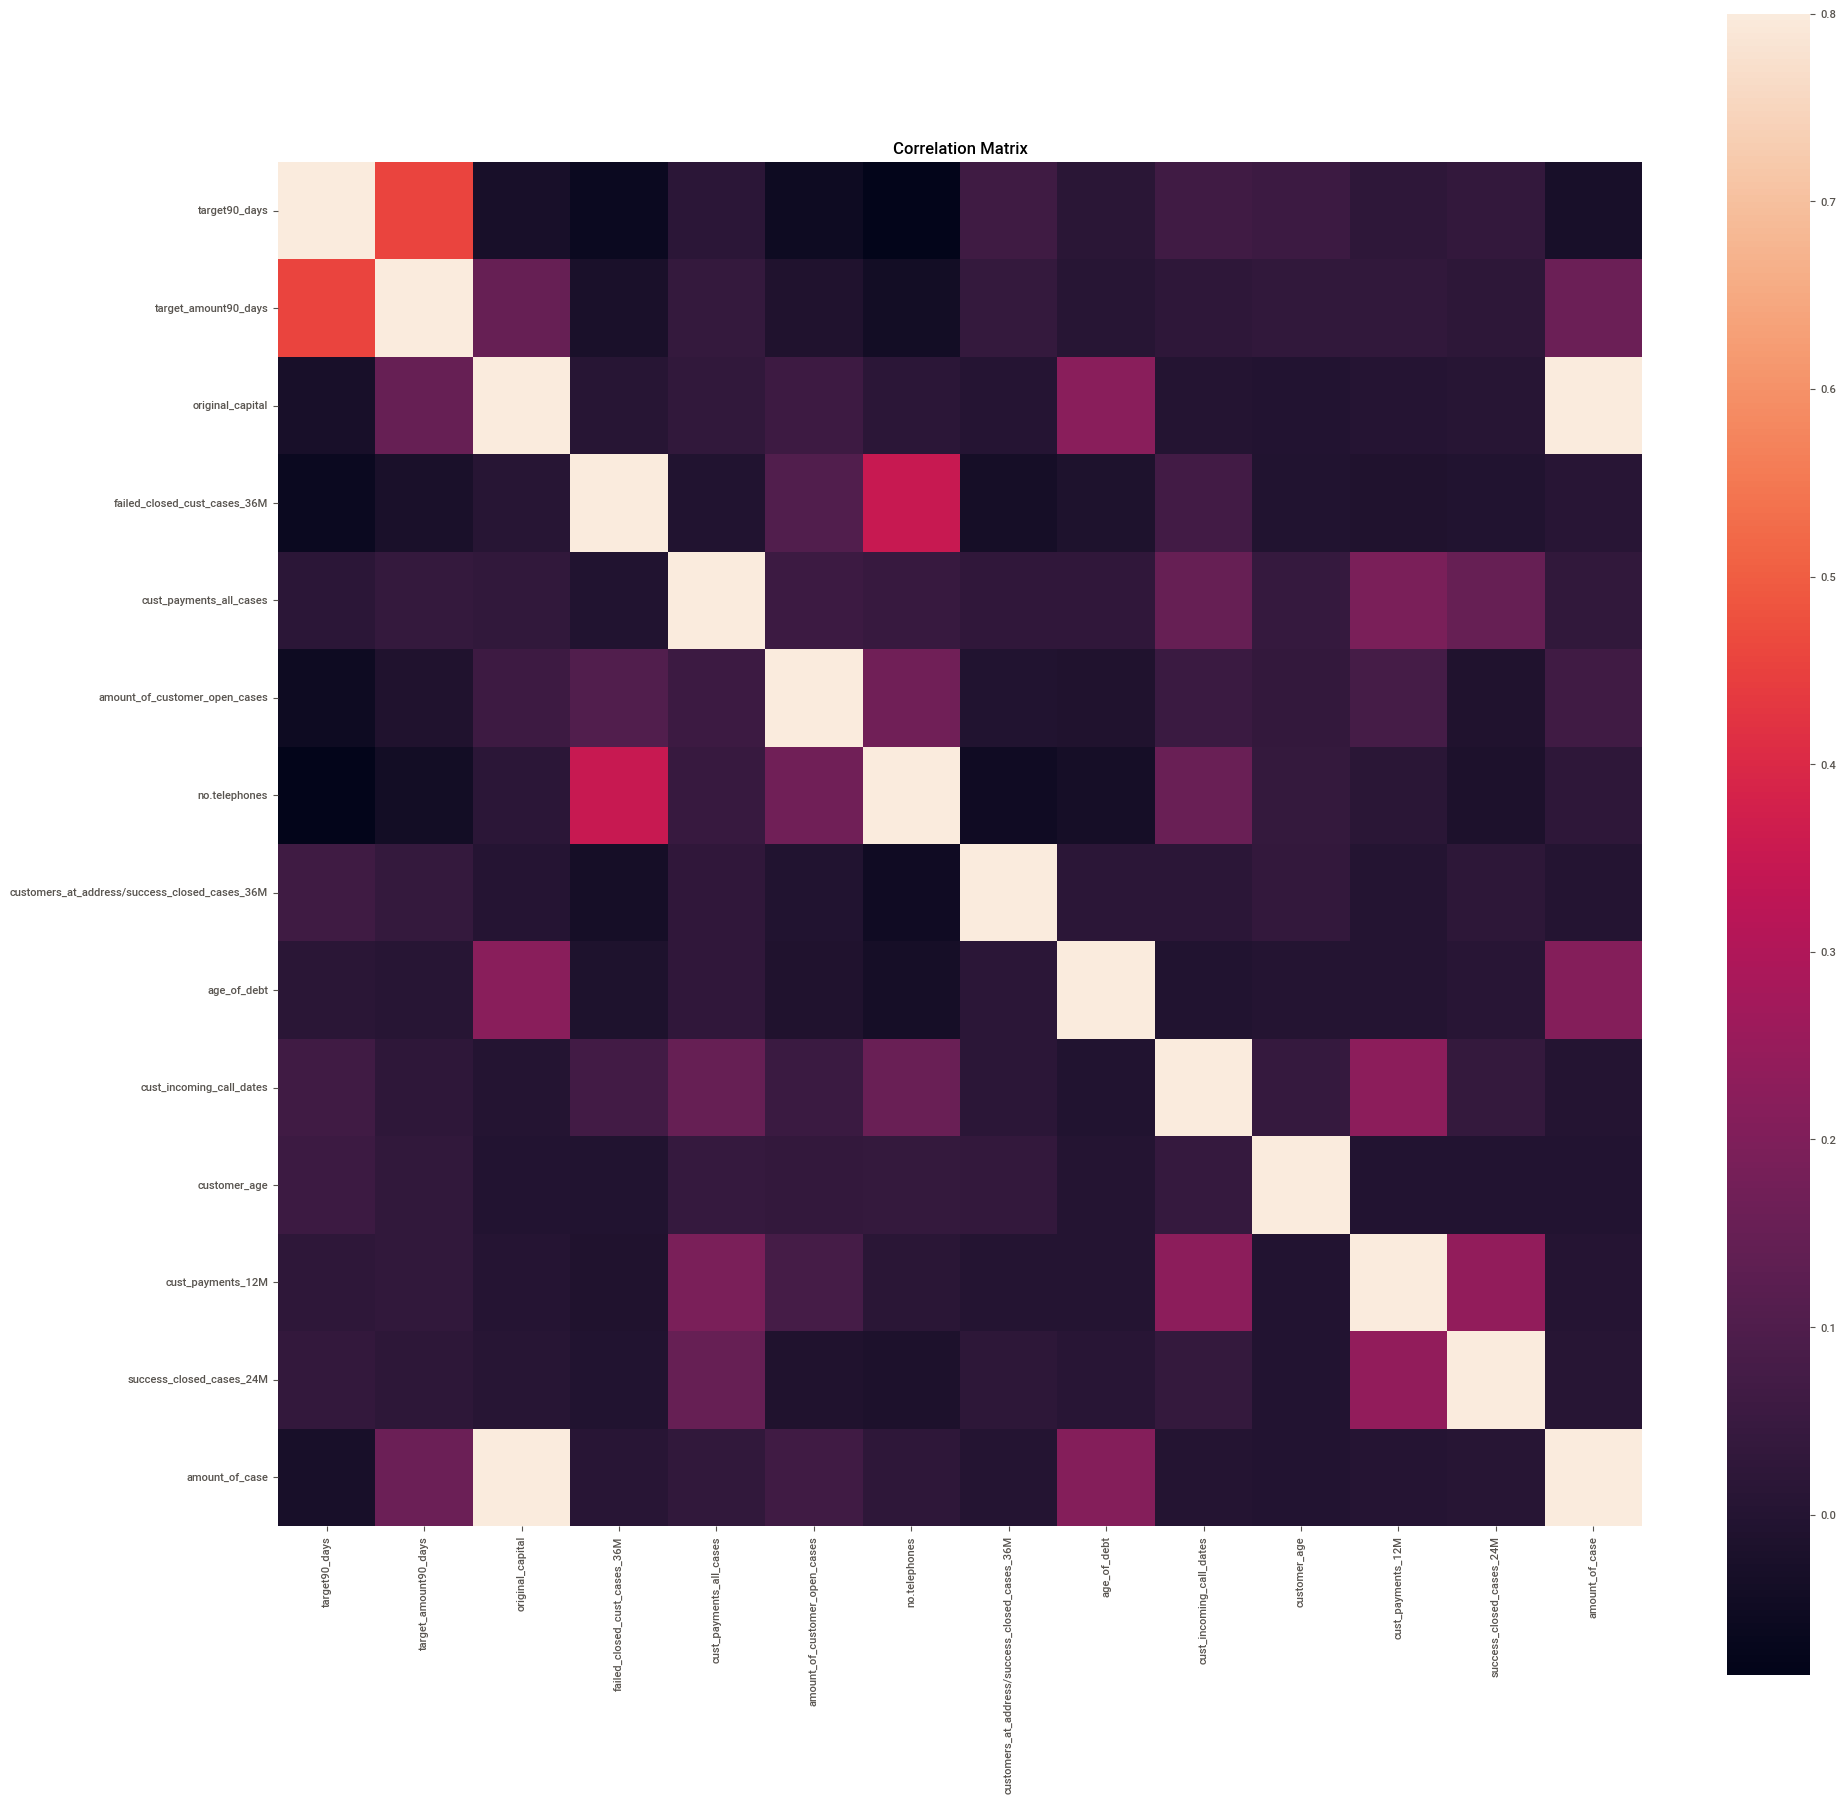

In [332]:
# Correlation Analysis
corr = df_dataset.select_dtypes(include=np.number).corr()
f, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(corr, vmax=.8, square=True)
plt.title('Correlation Matrix')
plt.show()

In [333]:
df_dataset.corr()

,target90_days,target_amount90_days,original_capital,failed_closed_cust_cases_36M,cust_payments_all_cases,amount_of_customer_open_cases,no.telephones,customers_at_address/success_closed_cases_36M,age_of_debt,cust_incoming_call_dates,customer_age,cust_payments_12M,success_closed_cases_24M,amount_of_case
target90_days,1.000000,0.455022,-0.029447,-0.060773,0.015346,-0.051445,-0.085102,0.062236,0.012971,0.064594,0.053495,0.024587,0.033723,-0.027913
target_amount90_days,0.455022,1.000000,0.149193,-0.024964,0.038019,-0.012134,-0.042509,0.036847,0.005711,0.023990,0.030312,0.030774,0.020208,0.157999
original_capital,-0.029447,0.149193,1.000000,0.006116,0.029755,0.059502,0.017770,0.003586,0.221894,-0.000576,-0.005002,0.003320,0.006351,0.955115
failed_closed_cust_cases_36M,-0.060773,-0.024964,0.006116,1.000000,-0.006194,0.102677,0.347225,-0.035838,-0.015670,0.069074,-0.008807,-0.011641,-0.006692,0.008785
cust_payments_all_cases,0.015346,0.038019,0.029755,-0.006194,1.000000,0.056416,0.043866,0.027977,0.026166,0.148860,0.041711,0.190925,0.149066,0.032384
amount_of_customer_open_cases,-0.051445,-0.012134,0.059502,0.102677,0.056416,1.000000,0.170067,-0.007623,-0.012296,0.052853,0.033223,0.074043,-0.010468,0.063697
no.telephones,-0.085102,-0.042509,0.017770,0.347225,0.043866,0.170067,1.000000,-0.048982,-0.035476,0.156168,0.037316,0.013816,-0.016682,0.025305
customers_at_address/success_closed_cases_36M,0.062236,0.036847,0.003586,-0.035838,0.027977,-0.007623,-0.048982,1.000000,0.018288,0.016542,0.035798,-0.000773,0.021125,0.000484
age_of_debt,0.012971,0.005711,0.221894,-0.015670,0.026166,-0.012296,-0.035476,0.018288,1.000000,-0.006299,0.000121,-0.001202,0.008714,0.210353
cust_incoming_call_dates,0.064594,0.023990,-0.000576,0.069074,0.148860,0.052853,0.156168,0.016542,-0.006299,1.000000,0.040227,0.226333,0.037336,0.001225


In [334]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr

correlation(df_dataset, 0.8)

{'amount_of_case'}

<b> Comment <b> 

Based on the correlation analysis, we conclude that amount_of_case is dangerously correlated with original capital. That is why, we decided to drop this column. For the further analysis, we also decided to drop the target amount of 90 days, because it's the target variable for regresssiont task.

In [335]:
df_dataset.drop(["amount_of_case", "target_amount90_days"], axis=1, inplace=True)

### Scailing & Transformation

We apply Standard Scaler (based on standard deviation).

In [336]:
from sklearn.preprocessing import StandardScaler, RobustScaler
dataset1=df_dataset.copy()
std_scaler = StandardScaler()

for col in dataset1.select_dtypes(include=np.number):
    if col == "target90_days":
        continue
    dataset1[col] = std_scaler.fit_transform(dataset1[col].values.reshape(-1,1))
    
    
dataset1.head()

,keydate,target90_days,original_capital,industry_code,client_name,failed_closed_cust_cases_36M,cust_payments_all_cases,amount_of_customer_open_cases,no.telephones,customers_at_address/success_closed_cases_36M,age_of_debt,cust_incoming_call_dates,customer_age,cust_payments_12M,last_original_closing_code,success_closed_cases_24M
0,2017-08-12,0.0,-0.253831,K6622,1,3.645140e-01,-7.106768e-01,-0.163208,-0.507865,0.000000,-0.035703,-0.338723,0.530841,-8.081055e-01,1,2.521422e-16
1,2017-02-03,0.0,-0.310154,K6512,2,-4.426620e-16,-3.572967e-01,-0.286075,0.886547,0.000000,0.020156,1.092316,0.690331,-8.081055e-01,2,2.334117e-01
2,2017-02-17,0.0,-0.392267,K6512,3,-6.322721e-01,9.541315e-17,-0.286075,-0.507865,-1.122447,3.265089,-0.338723,0.451095,-9.587195e-17,3,2.521422e-16
3,2017-09-18,0.0,-0.100472,K6622,4,-4.426620e-16,9.541315e-17,-0.258170,-0.043061,2.837585,-0.492736,-0.338723,-1.223556,-9.587195e-17,4,2.521422e-16
4,2017-07-22,0.0,-0.330602,K6512,5,3.645140e-01,-6.771063e-01,-0.243295,1.351351,0.000000,1.111957,-0.338723,-0.186867,-8.081055e-01,1,2.521422e-16


array([[<AxesSubplot:title={'center':'keydate'}>,
        <AxesSubplot:title={'center':'target90_days'}>,
        <AxesSubplot:title={'center':'original_capital'}>,
        <AxesSubplot:title={'center':'failed_closed_cust_cases_36M'}>],
       [<AxesSubplot:title={'center':'cust_payments_all_cases'}>,
        <AxesSubplot:title={'center':'amount_of_customer_open_cases'}>,
        <AxesSubplot:title={'center':'no.telephones'}>,
        <AxesSubplot:title={'center':'customers_at_address/success_closed_cases_36M'}>],
       [<AxesSubplot:title={'center':'age_of_debt'}>,
        <AxesSubplot:title={'center':'cust_incoming_call_dates'}>,
        <AxesSubplot:title={'center':'customer_age'}>,
        <AxesSubplot:title={'center':'cust_payments_12M'}>],
       [<AxesSubplot:title={'center':'success_closed_cases_24M'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

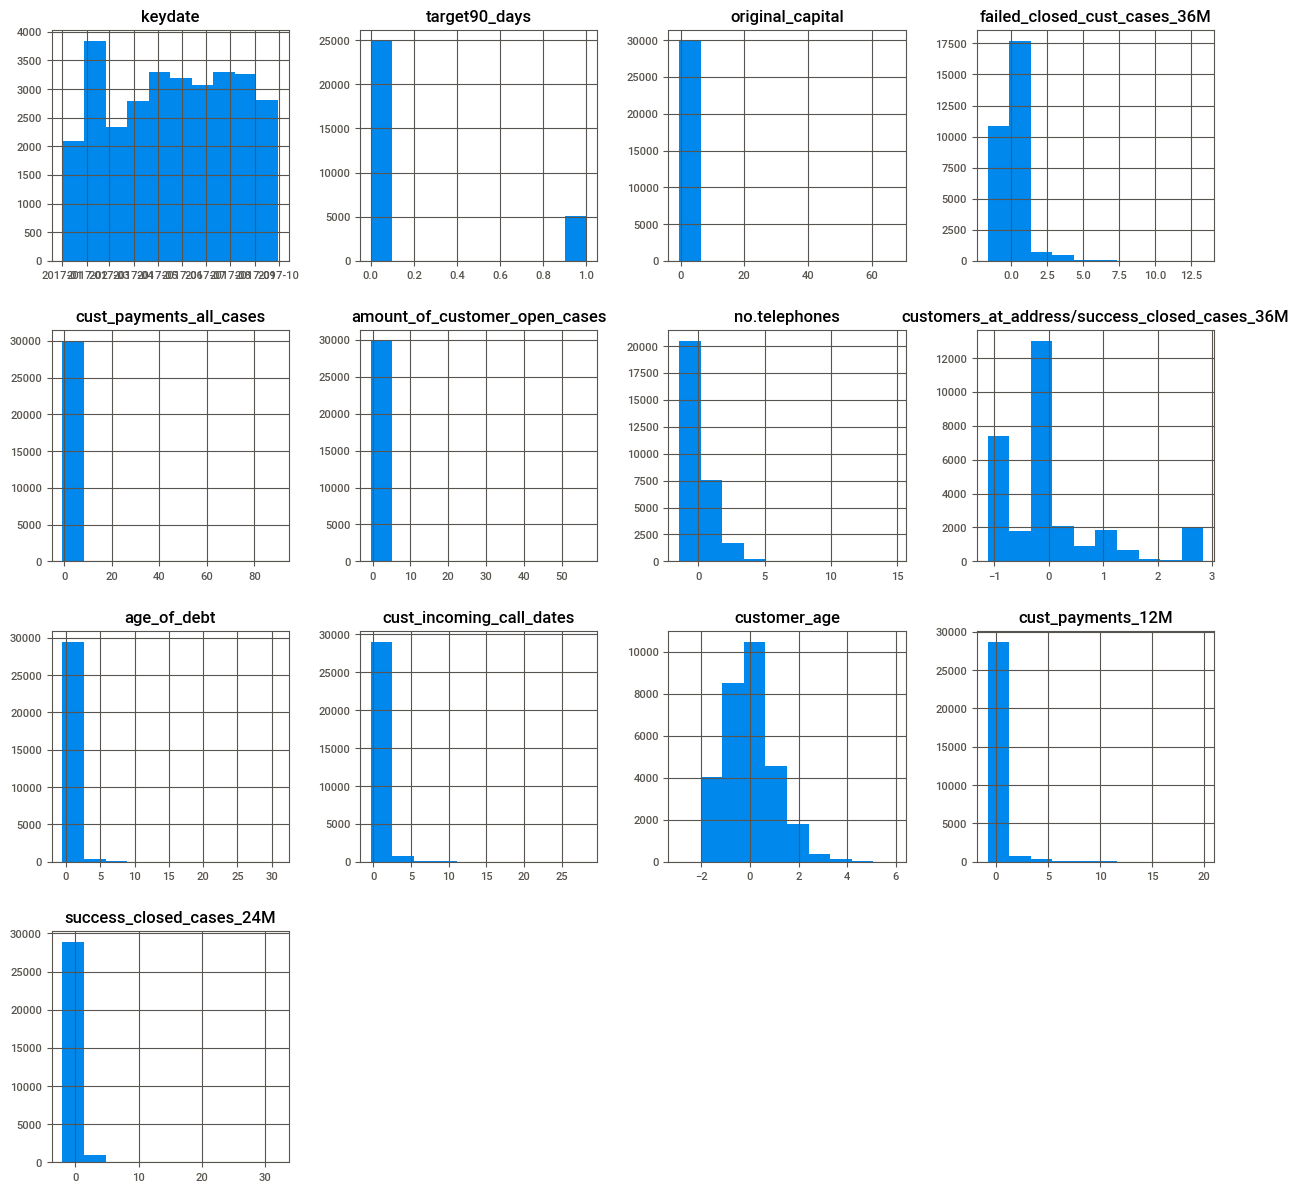

In [337]:
dataset1.hist(bins=10, figsize=(15,15))

### Feature engineering

In this part, I concentrate on adding possilby new features, transforming existing ones, and extracting extra information. 

I start with experimentation over keydate — extracting day, month, and year.

Then I check what we can do with categorical variables — I decided to drop client_name because it's a pretty unique thing for each of the client and not necessary for our model. morevoer, I convert the rest of th categorical variables to numerical ones.

Part of feature engineering process I did before while dropping non-essential columns.

In [338]:
# extract year, month, and day from the datetime object
dataset1['year'] = dataset1['keydate'].dt.year
dataset1['month'] = dataset1['keydate'].dt.month
dataset1['day'] = dataset1['keydate'].dt.day
dataset1.drop("keydate", axis=1, inplace=True)

In [339]:
#Check whether all columns are that important or we should drop them
print(dataset1.client_name.unique(), "\n\n")
print(dataset1.industry_code.unique())

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123' '124'
 '125' '126' '127' '128' '129' '130' '131' '132' '133' '134' '135' '136'
 '137' '138' '139' '140' '141' '142' '143' '144' '145' '146' '147' '148'
 '149' '150' '151' '152' '153' '154' '155' '156' '157' '158' '159' '160'
 '161' '162' '163' '164' '165' '166' '167' '168' '169' '170' '171' '172'
 '173' '174' '175' '176' '177' '178' '179' '180' '181'] 


['K6

In [340]:
#Drop Client Name
dataset1.drop("client_name", axis=1, inplace=True)

In [341]:
#Convert Industry Code
dataset2=dataset1.reset_index(drop=True).copy()
for i, code in enumerate(dataset2['industry_code']):
    new_code = int(code.strip()[1:])  # remove the first character (K) and convert to int
    dataset2.at[i, 'industry_code'] = new_code  # assign the new numeric code to the DataFrame

In [343]:
dataset2.industry_code.value_counts()

6512    17305
6622    9915 
6619    1391 
6419    909  
6499    410  
6491    24   
6420    15   
6511    6    
Name: industry_code, dtype: int64

In [344]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29975 entries, 0 to 29974
Data columns (total 17 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   target90_days                                  29975 non-null  float64
 1   original_capital                               29975 non-null  float64
 2   industry_code                                  29975 non-null  object 
 3   failed_closed_cust_cases_36M                   29975 non-null  float64
 4   cust_payments_all_cases                        29975 non-null  float64
 5   amount_of_customer_open_cases                  29975 non-null  float64
 6   no.telephones                                  29975 non-null  float64
 7   customers_at_address/success_closed_cases_36M  29975 non-null  float64
 8   age_of_debt                                    29975 non-null  float64
 9   cust_incoming_call_dates                       299

In [345]:
dataset2['last_original_closing_code'] = pd.to_numeric(dataset2['last_original_closing_code'])
dataset2['industry_code'] = pd.to_numeric(dataset2['industry_code'])

In [346]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29975 entries, 0 to 29974
Data columns (total 17 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   target90_days                                  29975 non-null  float64
 1   original_capital                               29975 non-null  float64
 2   industry_code                                  29975 non-null  int64  
 3   failed_closed_cust_cases_36M                   29975 non-null  float64
 4   cust_payments_all_cases                        29975 non-null  float64
 5   amount_of_customer_open_cases                  29975 non-null  float64
 6   no.telephones                                  29975 non-null  float64
 7   customers_at_address/success_closed_cases_36M  29975 non-null  float64
 8   age_of_debt                                    29975 non-null  float64
 9   cust_incoming_call_dates                       299

### Splitting Data and Solving Imbalance

To solve the issue of imbalance, I decided to go with undersampling and oversampling and compare the results. I considered the following methods:

Techniques for Undersampling:

Random Sampling
Cluster
Tomek Links
Undersampling with ensemble learning
Techniques for Oversampling

Random Sampling
SMOTE
ADASYN — Improved Version of SMOTE
Augmentation
and I dedcided in both cases to choose Random Sampling. This is because it will provide the exact environment to compare the methods (Random technique in both cases).

Undersampling

Advantages:

Help improve the runtime of the model & solve the memory problems by reducing the number of training data
Disadvantages:

Can discard useful information
Possibility to choose a biased sample which can cause the model toperform poorly on real unseen data.
Oversampling

Main Advantage:

No information loss
Disadvantages:

Possibility of overfitting since it replicates the minority class events.

In [348]:
from sklearn.model_selection import train_test_split

data_under = dataset2.copy()
data_over = dataset2.copy()

under_target = data_under.target90_days
under_predictors = data_under.drop("target90_days", axis=1)

over_target = data_over.target90_days
over_predictors = data_over.drop("target90_days", axis=1)

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(under_predictors, under_target, test_size=0.3, random_state=42, stratify=under_target)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(over_predictors, over_target, test_size=0.3, random_state=42, stratify=over_target)


(array([17440.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3542.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

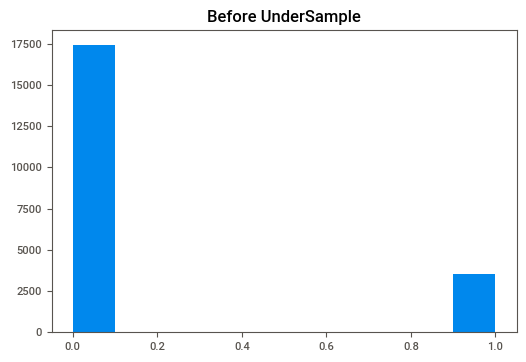

In [349]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.9, random_state=42)
X_resample_under, y_resample_under = rus.fit_resample(X_train_under, y_train_under)
colors = ['#ef8a62' if class_ == 0 else '#f7f7f7' if class_ == 1 else '#67a9cf' for class_ in y_resample_under]

import matplotlib
plt.title("Before UnderSample")
matplotlib.pyplot.hist(y_train_under)

Text(0.5, 1.0, 'After RandomUnderSampler')

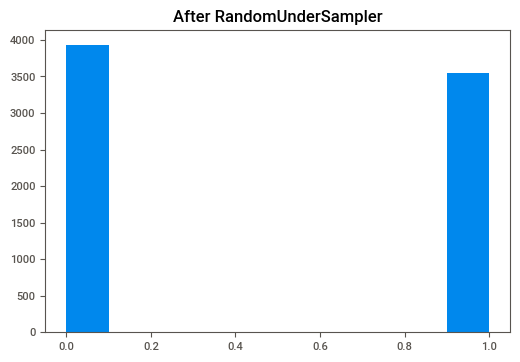

In [350]:
matplotlib.pyplot.hist(y_resample_under)
plt.title("After RandomUnderSampler")

(array([17440.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3542.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

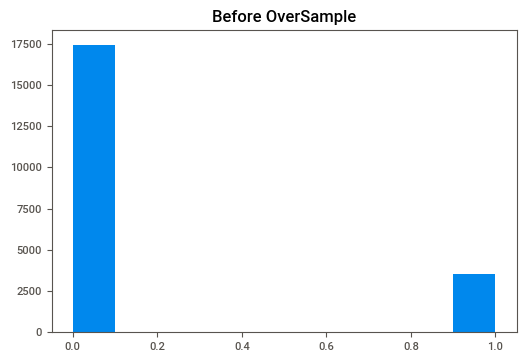

In [351]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.9, random_state=0)
X_resample_over, y_resample_over = ros.fit_resample(X_train_over, y_train_over)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resample_over]

import matplotlib
plt.title("Before OverSample")
matplotlib.pyplot.hist(y_train_over)

Text(0.5, 1.0, 'After RandomUnderSampler')

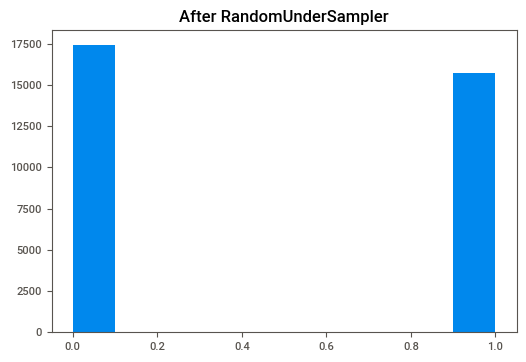

In [353]:
matplotlib.pyplot.hist(y_resample_over)
plt.title("After RandomUnderSampler")

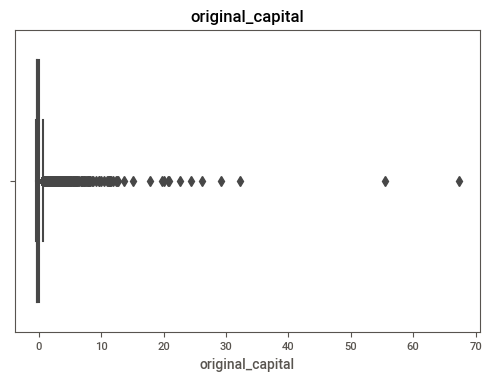

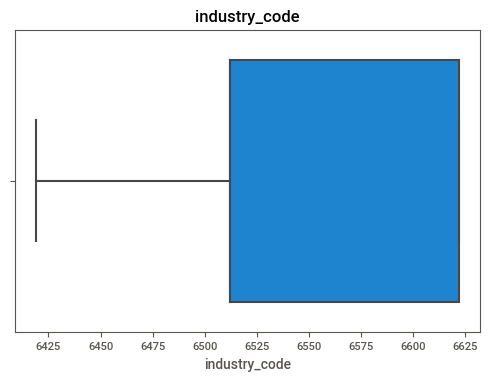

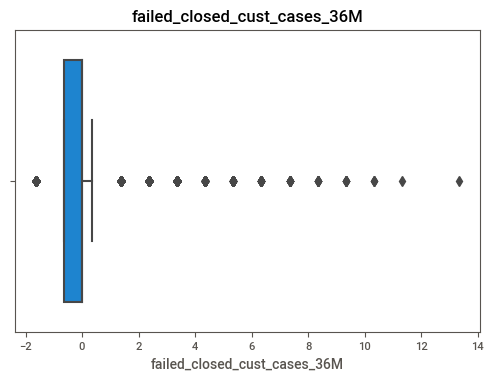

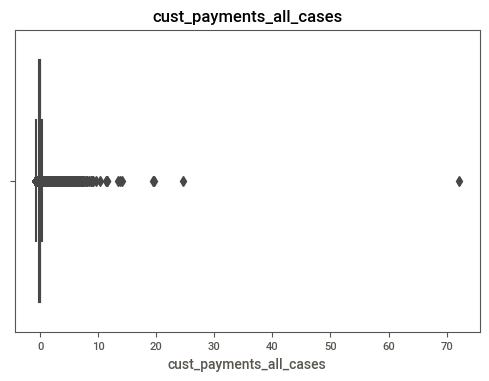

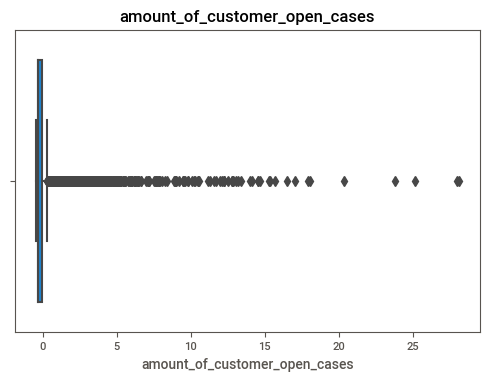

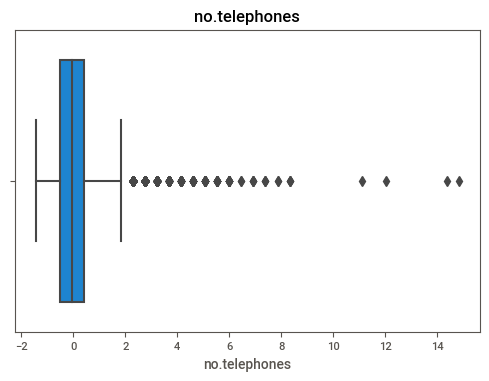

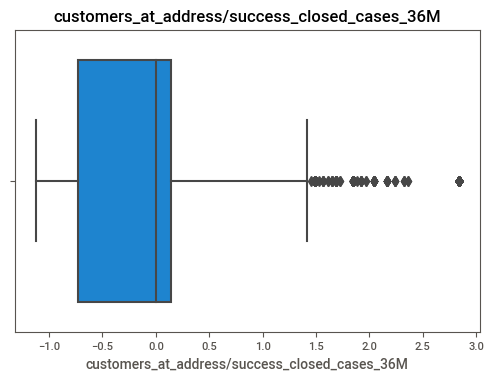

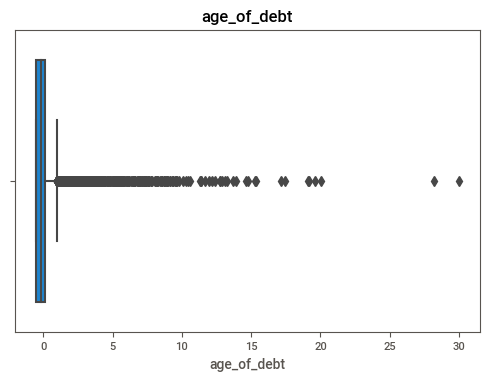

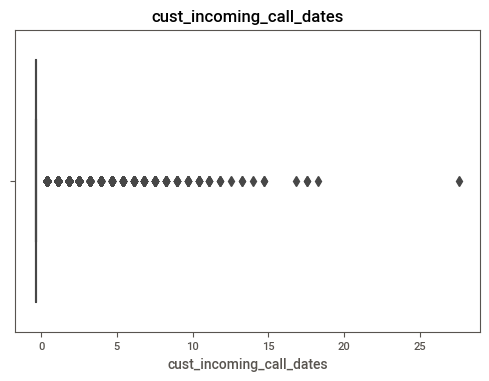

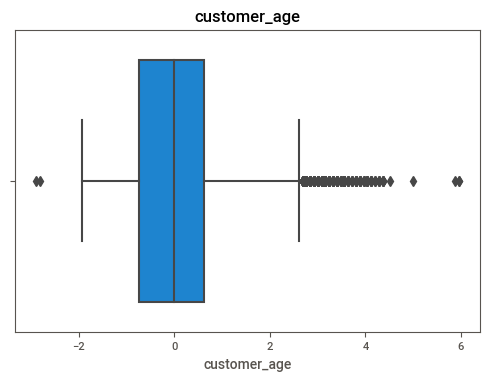

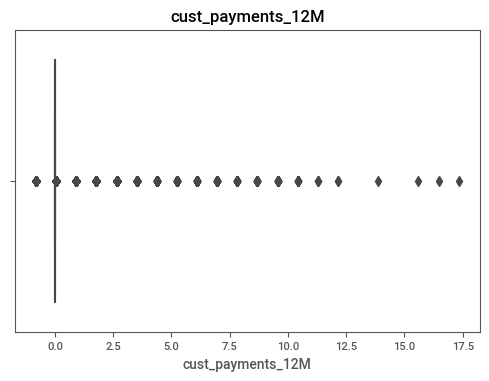

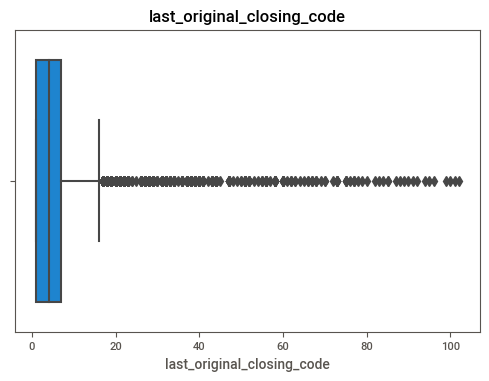

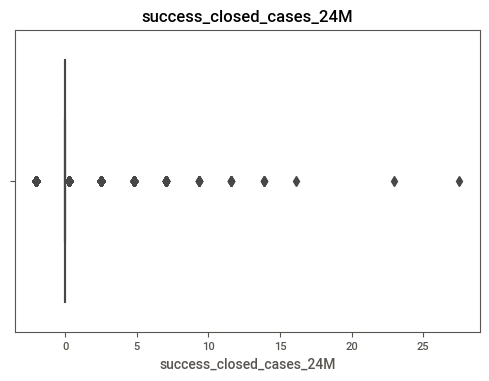

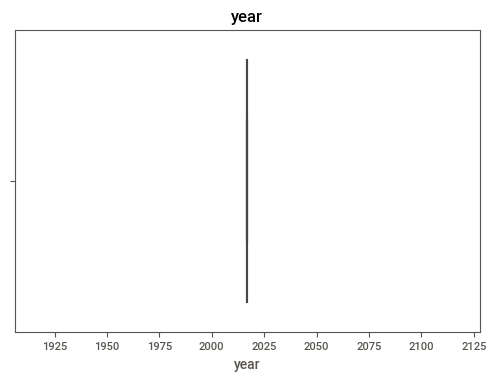

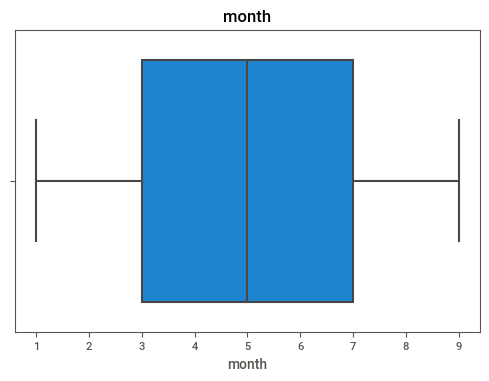

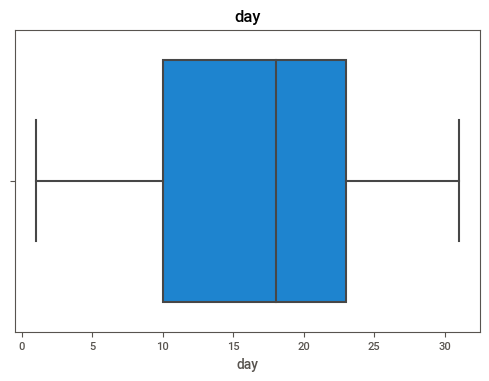

In [354]:
#Outlier Detection

# plot boxplot for each numeric column
for col in X_train_under.columns:
    sns.boxplot(X_train_under[col])
    plt.title(col)
    plt.show()

In [355]:
columns=X_train_under.columns
new_under=pd.concat([X_resample_under, y_resample_under], axis=1)
new_over=pd.concat([X_resample_over, y_resample_over], axis=1)

def remove_outliers(dataset, column):
    q1, q3 = np.percentile(dataset[column], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    dataset = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)]
    return dataset
        

for col in columns:
    over_without_outlier=remove_outliers(new_over, col)
    under_without_outlier=remove_outliers(new_under, col)



## Modeling — Undersampling data

In [356]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
import warnings

warnings.filterwarnings("ignore")

In [357]:
under_target = under_without_outlier.target90_days
under_predictors = under_without_outlier.drop("target90_days", axis=1)

over_target = over_without_outlier.target90_days
over_predictors = over_without_outlier.drop("target90_days", axis=1)

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(under_predictors, under_target, test_size=0.3, random_state=42, stratify=under_target)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(over_predictors, over_target, test_size=0.3, random_state=42, stratify=over_target)

In [358]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Decision Tree Classifier
dtc = DecisionTreeClassifier()

# Define the hyperparameters to tune
parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': [3, 4, 5, 6], 
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3]}

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(dtc, parameters, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_under, y_train_under)

# Print the best hyperparameters found
print("Best parameters: ", grid_search.best_params_)

# Use the best hyperparameters to train the model
best_dtc = grid_search.best_estimator_
best_dtc.fit(X_train_under, y_train_under)

# Predict the classes and probabilities on the test set
y_pred = best_dtc.predict(X_test_under)
y_proba = best_dtc.predict_proba(X_test_under)[:, 1]

# Compute the F1 score and AUC-ROC score
f1 = f1_score(y_test_under, y_pred)
auc_roc = roc_auc_score(y_test_under, y_proba)

# Print the F1 score and AUC-ROC score
print("F1 score: ", f1)
print("AUC-ROC score: ", auc_roc)

# Print the classification report
class_report = classification_report(y_test_under, y_pred)
print("Classification Report:\n", class_report)

/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected v

Best parameters:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}
F1 score:  0.559648158328752
AUC-ROC score:  0.6797892788212231
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.79      0.70      1181
         1.0       0.67      0.48      0.56      1063

    accuracy                           0.64      2244
   macro avg       0.65      0.63      0.63      2244
weighted avg       0.65      0.64      0.63      2244



In [359]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {'C': [0.1, 1, 10],
              'penalty': ['l1', 'l2']}

# Use GridSearchCV to find the best hyperparameters
lr_grid = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5)
lr_grid.fit(X_train_under, y_train_under)

# Train the model with the best hyperparameters
lr_best = LogisticRegression(random_state=42, **lr_grid.best_params_)
lr_best.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred = lr_best.predict(X_test_under)
y_pred_proba = lr_best.predict_proba(X_test_under)[:,1] # probability scores for class 1

# Compute the evaluation metrics
f1 = f1_score(y_test_under, y_pred)
auc_roc = roc_auc_score(y_test_under, y_pred_proba)
report = classification_report(y_test_under, y_pred)

# Print the evaluation metrics
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)
print("Classification report:\n", report)


F1 score: 0.5696324951644101
AUC-ROC score: 0.6397459620536194
Classification report:
               precision    recall  f1-score   support

         0.0       0.62      0.65      0.63      1181
         1.0       0.59      0.55      0.57      1063

    accuracy                           0.60      2244
   macro avg       0.60      0.60      0.60      2244
weighted avg       0.60      0.60      0.60      2244



In [361]:
#Random Forest
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Random Forest Classifier
rfc = RandomForestClassifier()

# Define the hyperparameters to tune
parameters = {'n_estimators': [50, 100, 200, 500],
              'criterion': ['gini', 'entropy'], 
              'max_depth': [3, 4, 5, 6], 
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3]}

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(rfc, parameters, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_under, y_train_under)

# Print the best hyperparameters found
print("Best parameters: ", grid_search.best_params_)

# Use the best hyperparameters to train the model
best_rfc = grid_search.best_estimator_
best_rfc.fit(X_train_under, y_train_under)

# Predict the classes and probabilities on the test set
y_pred = best_rfc.predict(X_test_under)
y_proba = best_rfc.predict_proba(X_test_under)[:, 1]

# Compute the F1 score and AUC-ROC score
f1 = f1_score(y_test_under, y_pred)
auc_roc = roc_auc_score(y_test_under, y_proba)

# Print the F1 score and AUC-ROC score
print("F1 score: ", f1)
print("AUC-ROC score: ", auc_roc)

# Print the classification report
class_report = classification_report(y_test_under, y_pred)
print("Classification Report:\n", class_report)


/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected v

Best parameters:  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 50}
F1 score:  0.6045785639958376
AUC-ROC score:  0.7126480500683844
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.76      0.70      1181
         1.0       0.68      0.55      0.60      1063

    accuracy                           0.66      2244
   macro avg       0.66      0.66      0.65      2244
weighted avg       0.66      0.66      0.66      2244



In [362]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [50, 100, 200],
              'max_depth': [3, 4, 5]}

# Use GridSearchCV to find the best hyperparameters
gbc_grid = GridSearchCV(gbc, param_grid, scoring='roc_auc', cv=5)
gbc_grid.fit(X_train_under, y_train_under)

# Train the model with the best hyperparameters
gbc_best = GradientBoostingClassifier(random_state=42, **gbc_grid.best_params_)
gbc_best.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred = gbc_best.predict(X_test_under)
y_pred_proba = gbc_best.predict_proba(X_test_under)[:,1] # probability scores for class 1

# Compute the evaluation metrics
f1 = f1_score(y_test_under, y_pred)
auc_roc = roc_auc_score(y_test_under, y_pred_proba)
report = classification_report(y_test_under, y_pred)

# Print the evaluation metrics
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)
print("Classification report:\n", report)


F1 score: 0.614070351758794
AUC-ROC score: 0.7060633119404686
Classification report:
               precision    recall  f1-score   support

         0.0       0.66      0.73      0.69      1181
         1.0       0.66      0.57      0.61      1063

    accuracy                           0.66      2244
   macro avg       0.66      0.65      0.65      2244
weighted avg       0.66      0.66      0.66      2244



In [363]:
#XGBoost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV

# Define XGBoost classifier
xgb = XGBClassifier()

# Define parameter grid for hyperparameter tuning
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7]
}

# Define grid search with cross-validation
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search to the training data
grid_search.fit(X_train_under, y_train_under)

# Get the best parameters and score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

# Train the XGBoost classifier with the best parameters
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred = xgb_best.predict(X_test_under)
y_proba = xgb_best.predict_proba(X_test_under)[:,1]

# Calculate evaluation metrics
f1 = f1_score(y_test_under, y_pred)
roc_auc = roc_auc_score(y_test_under, y_proba)
class_report = classification_report(y_test_under, y_pred)

# Print evaluation metrics
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)
print("Classification Report:", class_report)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score:  0.6204891027120174
F1 Score: 0.6189283925888834
AUC-ROC Score: 0.7123899656126359
Classification Report:               precision    recall  f1-score   support

         0.0       0.66      0.73      0.69      1181
         1.0       0.66      0.58      0.62      1063

    accuracy                           0.66      2244
   macro avg       0.66      0.66      0.66      2244
weighted avg       0.66      0.66      0.66      2244



In [364]:
#LightGMB
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV

# Define LightGBM classifier
lgbm = lgb.LGBMClassifier()

# Define parameter grid for hyperparameter tuning
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7]
}

# Define grid search with cross-validation
grid_search = GridSearchCV(lgbm, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search to the training data
grid_search.fit(X_train_under, y_train_under)

# Get the best parameters and score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

# Train the LightGBM classifier with the best parameters
lgbm_best = lgb.LGBMClassifier(**best_params)
lgbm_best.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred = lgbm_best.predict(X_test_under)
y_proba = lgbm_best.predict_proba(X_test_under)[:,1]

# Calculate evaluation metrics
f1 = f1_score(y_test_under, y_pred)
roc_auc = roc_auc_score(y_test_under, y_proba)
class_report = classification_report(y_test_under, y_pred)

# Print evaluation metrics
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)
print("Classification Report:", class_report)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


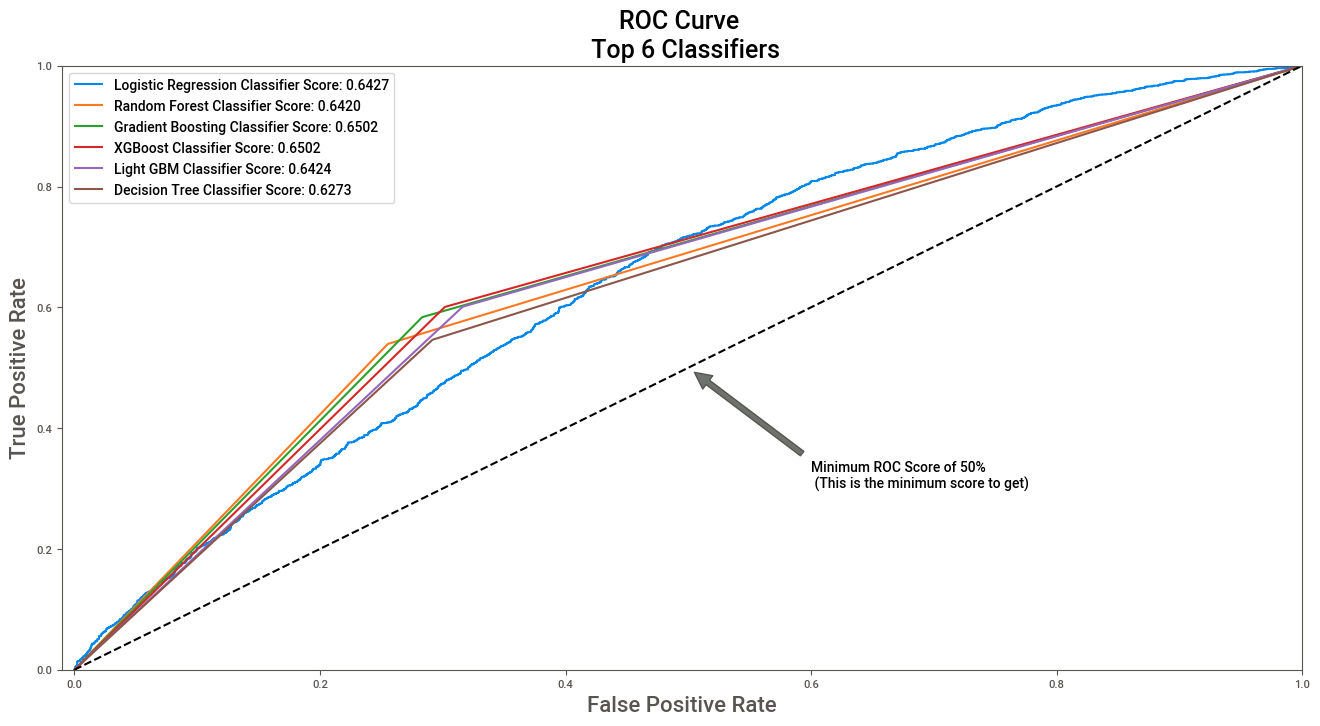

In [367]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

"""
The code below is created by author of this submission to Kaggle. It serves an inspiration.
Source: https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

"""

log_reg_pred = cross_val_predict(lr_best, X_train_under, y_train_under, cv=5,
                             method="decision_function")

best_rfc_pred=cross_val_predict(best_rfc, X_train_under, y_train_under, cv=5)

gbc_best_pred = cross_val_predict(gbc_best, X_train_under, y_train_under, cv=5)
xgb_best_pred = cross_val_predict(xgb_best, X_train_under, y_train_under, cv=5)

lgbm_best_pred = cross_val_predict(lgbm_best, X_train_under, y_train_under, cv=5)

tree_pred_pred = cross_val_predict(best_dtc, X_train_under, y_train_under, cv=5)

log_fpr, log_tpr, log_thresold = roc_curve(y_train_under, log_reg_pred)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_train_under, best_rfc_pred)
gbc_fpr, gbc_tpr, gbc_threshold = roc_curve(y_train_under, gbc_best_pred)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_train_under, xgb_best_pred)
lgbm_fpr, lgbm_tpr, lgbm_threshold = roc_curve(y_train_under, lgbm_best_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train_under, tree_pred_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr, gbc_fpr, gbc_tpr, xgb_fpr, xgb_tpr, lgbm_fpr, lgbm_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 6 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train_under, log_reg_pred)))
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train_under, best_rfc_pred)))
    plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier Score: {:.4f}'.format(roc_auc_score(y_train_under, gbc_best_pred)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train_under, gbc_best_pred)))
    plt.plot(lgbm_fpr, lgbm_tpr, label='Light GBM Classifier Score: {:.4f}'.format(roc_auc_score(y_train_under, lgbm_best_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train_under, tree_pred_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr, gbc_fpr, gbc_tpr, xgb_fpr, xgb_tpr, lgbm_fpr, lgbm_tpr, tree_fpr, tree_tpr)
plt.show()


## Modeling — Oversampling data

In [368]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Decision Tree Classifier
dtc = DecisionTreeClassifier()

# Define the hyperparameters to tune
parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': [3, 4, 5, 6], 
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3]}

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(dtc, parameters, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_over, y_train_over)

# Print the best hyperparameters found
print("Best parameters: ", grid_search.best_params_)

# Use the best hyperparameters to train the model
best_dtc = grid_search.best_estimator_
best_dtc.fit(X_train_over, y_train_over)

# Predict the classes and probabilities on the test set
y_pred = best_dtc.predict(X_test_over)
y_proba = best_dtc.predict_proba(X_test_over)[:, 1]

# Compute the F1 score and AUC-ROC score
f1 = f1_score(y_test_over, y_pred)
auc_roc = roc_auc_score(y_test_over, y_proba)

# Print the F1 score and AUC-ROC score
print("F1 score: ", f1)
print("AUC-ROC score: ", auc_roc)

# Print the classification report
class_report = classification_report(y_test_over, y_pred)
print("Classification Report:\n", class_report)

/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/bartekrzycki/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected v

Best parameters:  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1 score:  0.5733830845771144
AUC-ROC score:  0.7122546137820546
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.80      0.71      5232
         1.0       0.69      0.49      0.57      4709

    accuracy                           0.65      9941
   macro avg       0.66      0.65      0.64      9941
weighted avg       0.66      0.65      0.65      9941



In [369]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {'C': [0.1, 1, 10],
              'penalty': ['l1', 'l2']}

# Use GridSearchCV to find the best hyperparameters
lr_grid = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5)
lr_grid.fit(X_train_over, y_train_over)

# Train the model with the best hyperparameters
lr_best = LogisticRegression(random_state=42, **lr_grid.best_params_)
lr_best.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred = lr_best.predict(X_test_over)
y_pred_proba = lr_best.predict_proba(X_test_over)[:,1] # probability scores for class 1

# Compute the evaluation metrics
f1 = f1_score(y_test_over, y_pred)
auc_roc = roc_auc_score(y_test_over, y_pred_proba)
report = classification_report(y_test_over, y_pred)

# Print the evaluation metrics
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)
print("Classification report:\n", report)


F1 score: 0.5772392903504976
AUC-ROC score: 0.6477845062775881
Classification report:
               precision    recall  f1-score   support

         0.0       0.62      0.64      0.63      5232
         1.0       0.59      0.57      0.58      4709

    accuracy                           0.61      9941
   macro avg       0.61      0.60      0.60      9941
weighted avg       0.61      0.61      0.61      9941



In [370]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Random Forest Classifier
rfc = RandomForestClassifier()

# Define the hyperparameters to tune
parameters = {'n_estimators': [50, 100, 200, 500],
              'criterion': ['gini', 'entropy'], 
              'max_depth': [3, 4, 5, 6], 
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3]}

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(rfc, parameters, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_over, y_train_over)

# Print the best hyperparameters found
print("Best parameters: ", grid_search.best_params_)

# Use the best hyperparameters to train the model
best_rfc = grid_search.best_estimator_
best_rfc.fit(X_train_over, y_train_over)

# Predict the classes and probabilities on the test set
y_pred = best_rfc.predict(X_test_over)
y_proba = best_rfc.predict_proba(X_test_over)[:, 1]

# Compute the F1 score and AUC-ROC score
f1 = f1_score(y_test_over, y_pred)
auc_roc = roc_auc_score(y_test_over, y_proba)

# Print the F1 score and AUC-ROC score
print("F1 score: ", f1)
print("AUC-ROC score: ", auc_roc)

# Print the classification report
class_report = classification_report(y_test_over, y_pred)
print("Classification Report:\n", class_report)

Best parameters:  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
F1 score:  0.6160957686381415
AUC-ROC score:  0.7407675449704938
Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.78      0.72      5232
         1.0       0.70      0.55      0.62      4709

    accuracy                           0.67      9941
   macro avg       0.68      0.67      0.67      9941
weighted avg       0.68      0.67      0.67      9941



In [371]:
#Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Define the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [50, 100, 200],
              'max_depth': [3, 4, 5]}

# Use GridSearchCV to find the best hyperparameters
gbc_grid = GridSearchCV(gbc, param_grid, scoring='roc_auc', cv=5)
gbc_grid.fit(X_train_over, y_train_over)

# Train the model with the best hyperparameters
gbc_best = GradientBoostingClassifier(random_state=42, **gbc_grid.best_params_)
gbc_best.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred = gbc_best.predict(X_test_over)
y_pred_proba = gbc_best.predict_proba(X_test_over)[:,1] # probability scores for class 1

# Compute the evaluation metrics
f1 = f1_score(y_test_over, y_pred)
auc_roc = roc_auc_score(y_test_over, y_pred_proba)
report = classification_report(y_test_over, y_pred)

# Print the evaluation metrics
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)
print("Classification report:\n", report)


F1 score: 0.8839232746687761
AUC-ROC score: 0.9295179362441495
Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      5232
         1.0       0.83      0.95      0.88      4709

    accuracy                           0.88      9941
   macro avg       0.89      0.89      0.88      9941
weighted avg       0.89      0.88      0.88      9941



In [372]:
#XGBoost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV

# Define XGBoost classifier
xgb = XGBClassifier()

# Define parameter grid for hyperparameter tuning
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7]
}

# Define grid search with cross-validation
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search to the training data
grid_search.fit(X_train_over, y_train_over)

# Get the best parameters and score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

# Train the XGBoost classifier with the best parameters
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred = xgb_best.predict(X_test_over)
y_proba = xgb_best.predict_proba(X_test_over)[:,1]

# Calculate evaluation metrics
f1 = f1_score(y_test_over, y_pred)
roc_auc = roc_auc_score(y_test_over, y_proba)
class_report = classification_report(y_test_over, y_pred)

# Print evaluation metrics
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)
print("Classification Report:", class_report)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
Best score:  0.8903722920107275
F1 Score: 0.9078158349425755
AUC-ROC Score: 0.9666615362735032
Classification Report:               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      5232
         1.0       0.87      0.95      0.91      4709

    accuracy                           0.91      9941
   macro avg       0.91      0.91      0.91      9941
weighted avg       0.91      0.91      0.91      9941



In [373]:
#LightGMB
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV

# Define LightGBM classifier
lgbm = lgb.LGBMClassifier()

# Define parameter grid for hyperparameter tuning
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7]
}

# Define grid search with cross-validation
grid_search = GridSearchCV(lgbm, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search to the training data
grid_search.fit(X_train_over, y_train_over)

# Get the best parameters and score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

# Train the LightGBM classifier with the best parameters
lgbm_best = lgb.LGBMClassifier(**best_params)
lgbm_best.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred = lgbm_best.predict(X_test_over)
y_proba = lgbm_best.predict_proba(X_test_over)[:,1]

# Calculate evaluation metrics
f1 = f1_score(y_test_over, y_pred)
roc_auc = roc_auc_score(y_test_over, y_proba)
class_report = classification_report(y_test_over, y_pred)

# Print evaluation metrics
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)
print("Classification Report:", class_report)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


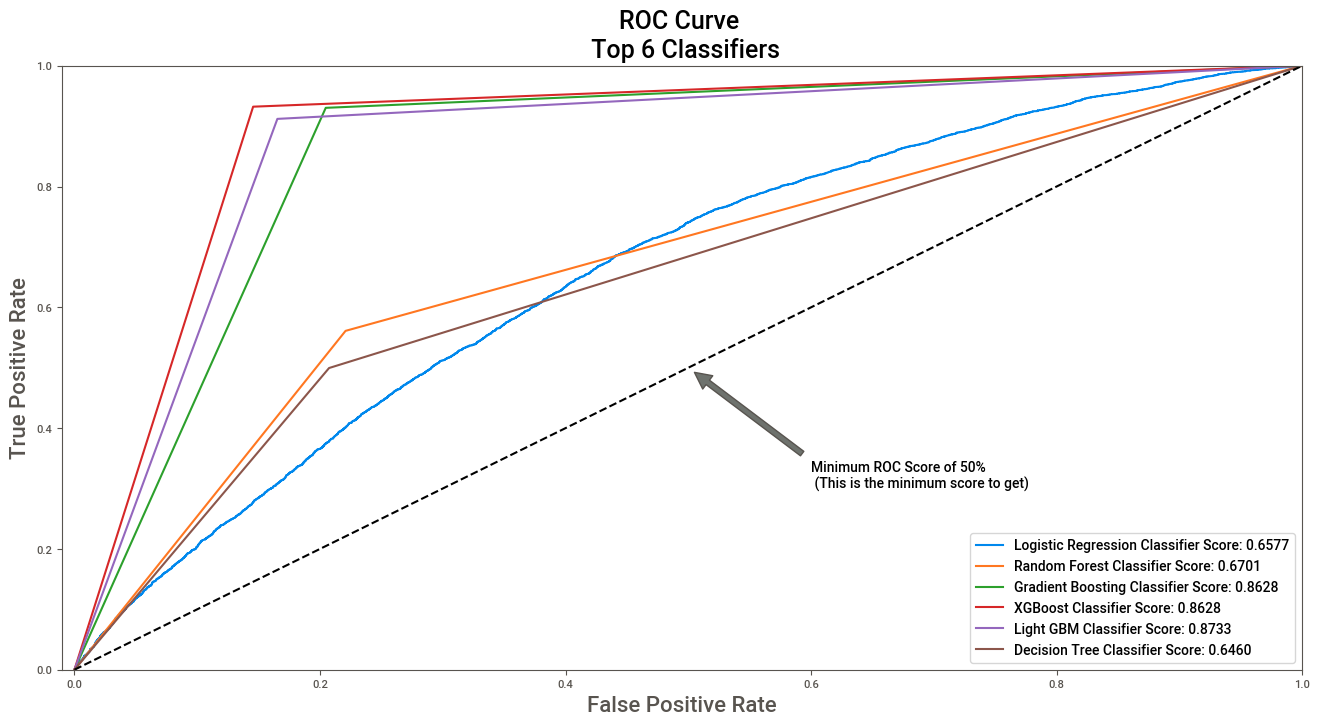

In [374]:
log_reg_pred = cross_val_predict(lr_best, X_train_over, y_train_over, cv=5,
                             method="decision_function")

best_rfc_pred=cross_val_predict(best_rfc, X_train_over, y_train_over, cv=5)

gbc_best_pred = cross_val_predict(gbc_best, X_train_over, y_train_over, cv=5)
xgb_best_pred = cross_val_predict(xgb_best, X_train_over, y_train_over, cv=5)

lgbm_best_pred = cross_val_predict(lgbm_best, X_train_over, y_train_over, cv=5)

tree_pred_pred = cross_val_predict(best_dtc, X_train_over, y_train_over, cv=5)


log_fpr, log_tpr, log_thresold = roc_curve(y_train_over, log_reg_pred)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_train_over, best_rfc_pred)
gbc_fpr, gbc_tpr, gbc_threshold = roc_curve(y_train_over, gbc_best_pred)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_train_over, xgb_best_pred)
lgbm_fpr, lgbm_tpr, lgbm_threshold = roc_curve(y_train_over, lgbm_best_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train_over, tree_pred_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr, gbc_fpr, gbc_tpr, xgb_fpr, xgb_tpr, lgbm_fpr, lgbm_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 6 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train_over, log_reg_pred)))
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train_over, best_rfc_pred)))
    plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier Score: {:.4f}'.format(roc_auc_score(y_train_over, gbc_best_pred)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train_over, gbc_best_pred)))
    plt.plot(lgbm_fpr, lgbm_tpr, label='Light GBM Classifier Score: {:.4f}'.format(roc_auc_score(y_train_over, lgbm_best_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train_over, tree_pred_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr, gbc_fpr, gbc_tpr, xgb_fpr, xgb_tpr, lgbm_fpr, lgbm_tpr, tree_fpr, tree_tpr)
plt.show()


<b> Comment — Results Interpretation <b>
    
Summarizing the result we can define the end results:


Undersampling:
1. Decision Tree: 0.56
2. Logistic Regression: 0.64
3. Random Forest: 0.6
4. Gradient Boosting: 0.6
5. XGBoost: 0.62
6. LightGBM: 0.62

Oversampling:
1. Decision Tree: 0.57
2. Logistic Regression: 0.58
3. Random Forest: 0.62
4. Gradient Boosting: 0.88
5. XGBoost: 0.91
6. LightGBM: 0.89


The conclusions: 
1. More advanced models perform better — Decision Tree, Logistic Regression, Random Forest do not classify data as good as Boosting family algorithms.
2. Undersampling is not good method and loses with oversampling.
3. In each case F1 scores for class 0 is better than class 1, and it is the result for class 1 that reduces the overall score. 
4. I would expect SMOTE oversampling to provide much better results but due to technical problems I could not test that method. 
5. Oversampling provided a quite good results, especially using XGBoost. 

Why XGBoost performed the best? Some possible reasons:

1. When a dataset is oversampled, the number of instances in the minority class is increased by creating synthetic examples or replicating existing ones. This can lead to overfitting, where the model learns to memorize the training data instead of generalizing to unseen data. XGBoost addresses this problem by using a regularization which adds a penalty term to the loss function. 
2. Additionally, gradient boosting inside XGBoost helps the model to learn more robust decision boundaries and avoid overfitting.
3. Furthermore, hyperparameters of XGBoost were found such that they may reduce the overfitting while still recognizing patterns in data. However, they cost was high time of training the model and tunning hyperparameters.